In [2]:
#What: import libraries for Future use

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler



# Dataset 1: Oxford Response Tracker

Datacleaning and processing: Laura, Kim, (Philipp)

In [3]:
#What: load data from github.
#Data source: The Oxford Covid-19 Government Response Tracker (GitHub repo, university website) tracks individual policy measures across 17 indicators. Based on this data they calculate several indices to give an overall impression of government activity as described at https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/index_methodology.md#legacy-stringency-index.
#Definitions: In the script comments the word "Indicator" refers to the low level data collected by the Oxford University research team for each country and day (i.e. "C1_School closing" or "C2_Workplace closing"). The word "Index" refers to a data that has been calculated using the Indicators (i.e. "StringencyIndex" or "GovernmentResponseIndexForDisplay").
url="https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"
ox=pd.read_csv(url)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#What: show what kind of data is contained within column RegionName
#Why: Want to understand what RegionName is useful for
#Conclusion: Dataset includes information on national States within countries (US and UK). 

ox.RegionName.unique()

array([nan, 'England', 'Northern Ireland', 'Scotland', 'Wales', 'Alaska',
       'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
       'Connecticut', 'Washington DC', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas',
       'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland', 'Maine',
       'Michigan', 'Minnesota', 'Missouri', 'Mississippi', 'Montana',
       'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire',
       'New Jersey', 'New Mexico', 'Nevada', 'New York', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Virgin Islands', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming'], dtype=object)

In [5]:
#What: Remove data of national states from data set (keep only data reffering to an entire countries)
#Why: Dataset includes information on national States within countries (US and UK) but our analysis will only look at data on country'levels.

ox = ox[ox['RegionName'].isna()]

In [6]:
#What: Drop unecessary columns
#Why: RegionName - Defines national States within countries which we are not going to analyse and which we have removed before.
#     RegionCode - Defines national States within countries which we are not going to analyse and which we have removed before.
#     M1_wildcard - Describes "Record policy announcements that do not fit anywhere else" but is always NaN in Dataset
#     ...IndexForDisplay - Analog to repective Index, but includes a calculation to fill missing data in the most recent 7 days. As we will only look at data until 22 September, this column is identical with original Index

ox=ox.drop(['RegionName','RegionCode','M1_Wildcard', 'StringencyLegacyIndex', 'StringencyIndexForDisplay','StringencyLegacyIndexForDisplay','GovernmentResponseIndexForDisplay', 'ContainmentHealthIndexForDisplay', 'EconomicSupportIndexForDisplay'], axis=1)

In [7]:
#What: Change index to a combination of CountryCode and Date. For this first convert Date to string and combine it with Country Cody by creating a new Column names CountryCodeDate. After setting the index, the new variable is no longer needed and removed. The set_index command removes CountryCodeDate automatically.
#Why: To enable logical slicing along index.

ox['CountryCodeDate']=ox.CountryCode +ox.Date.map(str)
ox.set_index('CountryCodeDate',inplace=True)


In [8]:
#What: Remove all data rows for dates after 22 Sept
#Why: The data quality in terms of data availability begins to fade out after 22 Sept. As we are going to analyse correlations with no prediction for future values it seems reasonable to cut the datasat at 22 Sept.

ox.drop(ox[ox['Date'] >20200922].index, inplace = True) 

In [9]:
ox.drop(ox[ox['CountryName'] =='Cayman Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='Pitcairn Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='British Virgin Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='Turks and Caicos Islands'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='United States Virgin Islands'].index, inplace = True) #Why: Country included in data set but with no data
ox.drop(ox[ox['CountryName'] =='Congo'].index, inplace = True) #Why: Has Nan value gap in index H2 and H2 in September. Before the gap values are 0, and after values are 1. This would therefore bias the analysis as the exact time of introducing the measure cannot be identified 
ox.drop(ox[ox['CountryName'] =='Montserrat'].index, inplace = True) #Why: Not sufficient data for index H1
ox.drop(ox[ox['CountryName'] =='Comoros'].index, inplace = True) #Why: Included in Dataset but no values except [ConfirmedCases] and [Confirmed Deaths]
ox.drop(ox[ox['CountryName'] =='Gibraltar'].index, inplace = True) #Why: Country data did not range up to chosen max-Date of 22 Sept. 
ox.drop(ox[ox['CountryName'] =='Falkland Islands'].index, inplace = True) #Why: Nodata on [E2_Debt/contract reliev] and on [H6_Facial Coverings]
ox.drop(ox[ox['CountryName'] =='Palestine'].index, inplace = True) #Why: Nodata on [H6_Facial Coverings]
ox.drop(ox[ox['CountryName'] =='Palestine'].index, inplace = True) #Why: Nodata on [H6_Facial Coverings]
ox.drop(ox[ox['CountryName'] =='Anguilla'].index, inplace = True) #Why: Nodata on [H6_Facial Coverings]


In [10]:
#Replacing NaN Values of indicators
#What: Define für NaNs in which indicator for which country should be written to which value.
#Why: By manually looking at NaNs of each country for each indicator, I have found that it makes sense not to replace them with always the same value but with different ones. 
#     For example: 
#     The Indicator [C2_Workplace closing] has some missing values for the countries Jordan(JOR) and Azerbaijan (AZE).
#     In Jordan the values of the dates before and after the NaNs is "0". Also, for the rows with the NaN the Indices calculated by using the [C2_Workplace closing] are equal to the Indices before and after the dates with Nan.
#     Therefore we can be certain that the missing value for Jordan in this case really is "0".
#     Similarly (by looking at the data for the indicators and indices of the rows affected by the NaNs and the rows before and after, we could identify that the real value for the Azerbaijan NaNs for [C2_Workplace closing] should be "2".

edit = [["C2_Workplace closing", "AZE", 2],
["C2_Workplace closing", "JOR", 0],
["C3_Cancel public events","JPN",1],
["C4_Restrictions on gatherings","LBN",0],
["C4_Restrictions on gatherings","MRT",0],
["C5_Close public transport","MYS",0],
["C6_Stay at home requirements","BGR",0],
["H1_Public information campaigns","ARG",2],
["H1_Public information campaigns","ARE",2],
["H1_Public information campaigns","UKR",2],
["H2_Testing policy","ARG",1],
["H2_Testing policy","ARE",3],
["H2_Testing policy","UKR",2],
["H2_Testing policy","NIC",0],
["H3_Contact tracing","MRT",0],
["H3_Contact tracing","UKR",2],
["E1_Income support","ARG",1],
["E1_Income support","GMB",0],
["E1_Income support","ISR",0],
["E1_Income support","PRI",0],
["E1_Income support","UKR",1],
["E1_Income support","ARE",0],
["E2_Debt/contract relief","ARG",1],
["E2_Debt/contract relief","UKR",1],
["E2_Debt/contract relief","ARE",2],
["H6_Facial Coverings","ABW",2],
["H6_Facial Coverings","CIV",4],
["H6_Facial Coverings","HKG",1],
["H6_Facial Coverings","LAO",0],
["H6_Facial Coverings","PAK",0]]

In [11]:
for i in edit:
    
    # What: Find all Indices where Countries in List and NAN values in Column are included in list. 
    meineIDs = ox[(ox["CountryCode"] == i[1]) & (ox[i[0]].isna())].index
    
    # What: replace the NaNs as defined in the list.
    ox.loc[meineIDs, i[0]] = i[2]

In [12]:
#Replacing NaN Values of indices and correct those indices that have been obscured by missing values in indicators (cf. above)
#What: Define für NaNs in which index for which country for which date should be written to which value.
#Why: By manually looking at NaNs of each country for each indicator, we have found that it makes sense not to replace them with always the same value but with different ones.
#     Also, in some cases if there was a NaN in the Indicator, to calculate the Index the data had assummed the value to be =0. In cases the value of the underlying indicator was found to be >0, the index is also corrected as follows:
#     This is also why in some cases where the missing value of the underlying indicator really could be replaced with 0 (cf. "edit"), no change of the index was required.

edit2 = [
["StringencyIndex","JPN20200525",34.26],
["GovernmentResponseIndex","JPN20200525",41.67],
["ContainmentHealthIndex","JPN20200525",35.61],
["EconomicSupportIndex","JPN20200525",[ox.loc["JPN20200525",['EconomicSupportIndex']]]],

["StringencyIndex","MRT20200707",[ox.loc["MRT20200707",['StringencyIndex']]]],
["GovernmentResponseIndex","MRT20200707",51.28],
["ContainmentHealthIndex","MRT20200707",56.06],
["EconomicSupportIndex","MRT20200707",[ox.loc["MRT20200707",['EconomicSupportIndex']]]],
               
["StringencyIndex","ARG20200702",92.59],
["GovernmentResponseIndex","ARG20200702",85.90],
["ContainmentHealthIndex","ARG20200702",87.99],
["EconomicSupportIndex","ARG20200702",75.00],

["StringencyIndex","ARE20200730",43.52],
["GovernmentResponseIndex","ARE20200730",53.21],
["ContainmentHealthIndex","ARE20200730",53.79],
["EconomicSupportIndex","ARE20200730",50.00],

["StringencyIndex","UKR20200907",62.50],
["GovernmentResponseIndex","UKR20200907",61.86],
["ContainmentHealthIndex","UKR20200907",66.29],
["EconomicSupportIndex","UKR20200907",37.50],
   
["StringencyIndex","UKR20200828",62.50],
["GovernmentResponseIndex","UKR20200828",61.86],
["ContainmentHealthIndex","UKR20200828",66.29],
["EconomicSupportIndex","UKR20200828",37.50],

["StringencyIndex","ARE20200730",43.52],
["GovernmentResponseIndex","ARE20200730",53.21],
["ContainmentHealthIndex","ARE20200730",53.79],
["EconomicSupportIndex","ARE20200730",50.00],

["StringencyIndex","NIC20200414",8.33],
["GovernmentResponseIndex","NIC20200414",8.33],
["ContainmentHealthIndex","NIC20200414",9.85],
["EconomicSupportIndex","NIC20200414",00.00],

["EconomicSupportIndex","GMB20200507",00.00],
["EconomicSupportIndex","GMB20200508",00.00],

["EconomicSupportIndex","ISR20200316",50.00],

["EconomicSupportIndex","PRI20200317",50.00],

["GovernmentResponseIndex","ABW20200922",58.33],
["ContainmentHealthIndex","ABW20200922",57.64],

["GovernmentResponseIndex","CIV20200908",54.46],
["ContainmentHealthIndex","CIV20200908",51.04],

["GovernmentResponseIndex","CIV20200907",54.46],
["ContainmentHealthIndex","CIV20200907",51.04],

["GovernmentResponseIndex","CIV20200906",54.46],
["ContainmentHealthIndex","CIV20200906",51.04],

["GovernmentResponseIndex","CIV20200905",54.46],
["ContainmentHealthIndex","CIV20200905",51.04],

["GovernmentResponseIndex","CIV20200904",54.46],
["ContainmentHealthIndex","CIV20200904",51.04],

["GovernmentResponseIndex","CIV20200903",54.46],
["ContainmentHealthIndex","CIV20200903",51.04],

["GovernmentResponseIndex","CIV20200902",54.46],
["ContainmentHealthIndex","CIV20200902",51.04],

["GovernmentResponseIndex","CIV20200901",54.46],
["ContainmentHealthIndex","CIV20200901",51.04],

["GovernmentResponseIndex","HKG20200922",69.05],
["ContainmentHealthIndex","HKG20200922",63.89],

["ConfirmedCases","FRA20200603",152208], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.) 
["ConfirmedCases","FRA20200604",152326], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.) 

["ConfirmedCases","ESP20200419",194717], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.) 
["ConfirmedCases","ESP20200525",236015], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","ITA20200620",238217], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.) 

["ConfirmedCases","JOR20200722",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200723",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200724",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200725",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200726",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200727",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200728",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200729",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200730",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200731",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200801",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200802",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200803",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","JOR20200804",1223], #Linear correction of days where confirmed cases have been incorrect. (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","LTU20200429",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200430",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200501",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200502",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200503",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200504",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200505",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200506",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200507",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200508",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200509",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LTU20200510",1449], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","LUX20200828",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200829",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200830",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200831",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200901",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200902",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200903",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200904",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200905",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200906",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200907",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200908",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200909",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200910",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200911",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200912",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200913",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200914",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200915",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200916",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200917",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200918",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200919",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200920",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200921",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","LUX20200922",7928], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","PRT20200503",25437], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","UGA20200521",260], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","UGA20200522",260], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","UGA20200523",260], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","UGA20200524",260], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","UGA20200525",260], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","UGA20200526",260], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","UGA20200527",260], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","UGA20200602",473], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","ECU20200507",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200508",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200509",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200510",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200511",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200512",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200513",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200514",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200515",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200516",31881], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU2020708",64131], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","ECU20200907",118045], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200908",118045], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200909",118045], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200910",118045], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200911",118045], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200912",118045], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","ECU20200913",118045], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","BEN20200520",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200521",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200522",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200523",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200524",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200525",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200526",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200527",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200528",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200529",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200530",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200531",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedCases","BEN20200601",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200602",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200603",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200604",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200605",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200606",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200607",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200608",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)


["ConfirmedCases","BEN20200609",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200610",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200611",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedCases","BEN20200612",339], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedDeaths","ESP20200522",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200523",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200524",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200525",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200526",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200527",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200528",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200529",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200530",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200531",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200601",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200602",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200603",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200604",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200605",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200606",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200607",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200608",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200609",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200610",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200611",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200612",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200613",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200614",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200615",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200616",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200617",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","ESP20200618",2794], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedDeaths","ESP20200812",28593], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedDeaths","ITA20200625",34675], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedDeaths","KGZ20200824",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200825",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200826",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200827",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200828",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200829",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200830",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200831",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedDeaths","KGZ20200901",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200902",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200903",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200904",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200905",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200906",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200907",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200908",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200909",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200910",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200911",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200912",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200913",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200914",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200915",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200916",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200917",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200918",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200919",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)

["ConfirmedDeaths","KGZ20200920",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200921",1500], #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
["ConfirmedDeaths","KGZ20200922",1500] #Linear correction of days where confirmed cases have been incorrect: Keep level of Total Number of Confirmed Cases on level of last plausible day.  (Total Number of Confirmed Cases has been smaller then the day before, which is not possible.)
]

In [13]:
for i in edit2:
    
    # What: Find all Indices for countris and dates as defined in list. 
    meineIDs = ox[(ox.index == i[1])].index
    
    # What: replace the NaNs or existing values as defined in the list.
    ox.loc[meineIDs, i[0]] = i[2]

In [14]:
#Tests to make sure that the above operation for replace Indicator NaN has been sucessful.
# Show distinct values for Ukraine [H1_Public information campaigns]. That way we can see if there are any NaNs remaining (This was tested for multiple values that have been repleced using the loop above)

#pd.unique(ox.loc[ox["CountryCode"]=="UKR", 'H1_Public information campaigns'])

#Prior to the NaN correction there was a NaN for Japan in [C3_Cancel public events] on 20200525. The following operation controls the value for that day and finds the corrected value.

#subset_JPN = ox[ox['CountryName'] == 'Japan']
#subset_JPN_20200525 = subset_JPN[subset_JPN['Date'] == 20200525]
#subset_JPN_20200524 = subset_JPN[subset_JPN['Date'] == 20200524]
#subset_20200525 = ox[ox['Date'] == 20200525]
#subset_JPN_20200525["C3_Cancel public events"]

In [15]:
# What: Check how many NaNs remain for each column
# Why: To test if NaN replacement using loops above has been sucessfull/complete
# Conclusion: 

pd.isna(ox).sum()

CountryName                                  0
CountryCode                                  0
Date                                         0
C1_School closing                            0
C1_Flag                                  16319
C2_Workplace closing                         0
C2_Flag                                  18783
C3_Cancel public events                      0
C3_Flag                                  15736
C4_Restrictions on gatherings                0
C4_Flag                                  17580
C5_Close public transport                    0
C5_Flag                                  28272
C6_Stay at home requirements                 0
C6_Flag                                  22508
C7_Restrictions on internal movement         0
C7_Flag                                  23433
C8_International travel controls             0
E1_Income support                            0
E1_Flag                                  23966
E2_Debt/contract relief                      0
E3_Fiscal mea

*Additions Kim* 
* gap filling ConfirmedCases and ConfirmedDeaths
* adding columns for ConfirmedCases_per_day and ConfirmedDeaths_per_day 

In [16]:
# drop unnecessary columns 
ox = ox.drop(['C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag', 'E1_Flag', 'H1_Flag', 'H6_Flag', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'E3_Fiscal measures'], axis=1)

pd.isna(ox).sum()

CountryName                                0
CountryCode                                0
Date                                       0
C1_School closing                          0
C2_Workplace closing                       0
C3_Cancel public events                    0
C4_Restrictions on gatherings              0
C5_Close public transport                  0
C6_Stay at home requirements               0
C7_Restrictions on internal movement       0
C8_International travel controls           0
E1_Income support                          0
E2_Debt/contract relief                    0
E4_International support                  13
H1_Public information campaigns            0
H2_Testing policy                          0
H3_Contact tracing                         4
H6_Facial Coverings                        0
ConfirmedCases                          9442
ConfirmedDeaths                         9442
StringencyIndex                            0
GovernmentResponseIndex                    0
Containmen

In [17]:
# WHAT: look for missing values in Confirmed Cases 
ox['ConfirmedCases'].isnull().sum(axis = 0)

# problem: nan values not only in the beginning of the year but also at other random places 
# solution to fill gaps: replace each nan with the ConfirmedCases value from the day before 

9442

In [18]:
# as we don't want to mess our data up, we first we have to fill the first day of each country 
# show number of cases on first day 
firstday = ox.loc[ox['Date'] == 20200101, 'ConfirmedCases']
firstday['CHN20200101']

27.0

In [19]:
# only China had confirmed cases on Jan, 01 
#--> replace nan in ConfirmedCases of other countries on first day with 0
ox.loc[(ox['Date'] == 20200101) & (ox['CountryCode']!="CHN"), 'ConfirmedCases'] = 0

In [20]:
# now we can apply forward fill
ox.loc[:,'ConfirmedCases'] = ox.loc[:,'ConfirmedCases'].ffill()

In [21]:
# check for nan values 
ox['ConfirmedCases'].isnull().sum(axis = 0)

0

In [22]:
#get confirmed cases per day 

#get difference from one day to the next day
ox['ConfirmedCases_per_day'] = ox['ConfirmedCases'].diff()

In [23]:
# set first day to 0 (otherwise we'll have negative values on the first day)
ox.loc[ox['Date'] == 20200101, 'ConfirmedCases_per_day'] = 0

In [24]:
# as we don't know how cases increased in China in 2019, we use the ConfirmedCases on Jan 01 as ConfirmedCases per day
ox.loc['CHN20200101', 'ConfirmedCases_per_day'] = ox.loc['CHN20200101', 'ConfirmedCases']

In [25]:
# do the same thing for confirmeddeaths

ox['ConfirmedDeaths'].isnull().sum(axis = 0)
firstday = ox.loc[ox['Date'] == 20200101, 'ConfirmedDeaths']


In [26]:
#nodeaths on the firstday 
ox.loc[(ox['Date'] == 20200101) & (ox['CountryCode']!="CHN"), 'ConfirmedDeaths'] = 0


In [27]:
#use forwardfill
ox.loc[:,'ConfirmedDeaths'] = ox.loc[:,'ConfirmedDeaths'].ffill()

In [28]:
# check for nan values 
ox['ConfirmedDeaths'].isnull().sum(axis = 0)

0

In [29]:
#get confirmed deaths per day 

#get difference from one day to the next day
ox['ConfirmedDeaths_per_day'] = ox['ConfirmedDeaths'].diff()

In [30]:
# set first day to 0 as there were no Covid-19 related deaths on Jan 01 (otherwise we'll have negative values on the first day)
ox.loc[ox['Date'] == 20200101, 'ConfirmedDeaths_per_day'] = 0


In [31]:
#Convert the Date column to datetime
ox.Date = pd.to_datetime(ox.Date, format='%Y%m%d')

In [32]:
#confirmed cases are delayed by incubation period and test evaluation
#therefore we shift confirmed cases by -7 days and confirmed deaths by -27 (source: https://www.mdpi.com/2077-0383/9/2/523/htm) 

ox['ConfirmedCases_per_day_shifted'] = ox['ConfirmedCases_per_day'].shift(-7)
ox['ConfirmedDeaths_per_day_shifted'] = ox['ConfirmedDeaths_per_day'].shift(-27)


In [33]:
#What: Calculate how many days the Coroona Virus has been present in each country
#Why: Need that information to compare the total Confirmed Cases between countries

ox['CountryCode'] = ox['CountryCode'].astype('category')
ox1 = ox[ox['ConfirmedCases'] > 0].groupby(['CountryCode']).size().reset_index(name='Days_Corona_in_Country') 


ox = pd.merge(ox, ox1, how = "inner", on=['CountryCode', 'CountryCode'])
ox


,CountryName,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,ConfirmedCases,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,ConfirmedCases_per_day,ConfirmedDeaths_per_day,ConfirmedCases_per_day_shifted,ConfirmedDeaths_per_day_shifted,Days_Corona_in_Country
0,Aruba,ABW,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,194
1,Aruba,ABW,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,194
2,Aruba,ABW,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,194
3,Aruba,ABW,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,194
4,Aruba,ABW,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46545,Zimbabwe,ZWE,2020-09-18,2.0,1.0,2.0,3.0,1.0,2.0,2.0,4.0,1.0,0.0,0.0,2.0,1.0,1.0,3.0,7633.0,224.0,76.85,64.29,70.83,25.0,35.0,0.0,NaN,NaN,186
46546,Zimbabwe,ZWE,2020-09-19,2.0,1.0,2.0,3.0,1.0,2.0,2.0,4.0,1.0,0.0,0.0,2.0,1.0,1.0,3.0,7647.0,224.0,76.85,64.29,70.83,25.0,14.0,0.0,NaN,NaN,186
46547,Zimbabwe,ZWE,2020-09-20,2.0,1.0,2.0,3.0,1.0,2.0,2.0,4.0,1.0,0.0,0.0,2.0,1.0,1.0,3.0,7672.0,225.0,76.85,64.29,70.83,25.0,25.0,1.0,NaN,NaN,186
46548,Zimbabwe,ZWE,2020-09-21,2.0,1.0,2.0,3.0,1.0,2.0,2.0,4.0,1.0,0.0,0.0,2.0,1.0,1.0,3.0,7683.0,225.0,76.85,64.29,70.83,25.0,11.0,0.0,NaN,NaN,186


# Dataset 2: Democracy Indices

Datacleaning and processing: Philipp

In [34]:
#Read the data from github

#Democracy Date from the worldbank info.worldbank.org: https://tinyurl.com/y47yngnu
EIU = "https://github.com/roady1988/codeathome_ds_11/blob/main/EIU.xlsx?raw=true"

#Democracyindex, source Wikipedia: https://de.wikipedia.org/wiki/Demokratieindex
INDEX2018 = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/INDEX2018.csv"
INDEX2019 = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/INDEX2019.csv"

#ISO3166 country code 2 and 3 letters english
ISO_en = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/ISO3166.csv"
#ISO3166 country code 2 letters german
ISO_de = "https://raw.githubusercontent.com/roady1988/codeathome_ds_11/main/german-iso-3166.csv"

#read all data
df_EIU = pd.read_excel(EIU, sheet_name="MERGEPublic", header = [0,1])
df_INDEX2018 = pd.read_csv(INDEX2018, decimal=",", sep=";", encoding = 'iso-8859-1', index_col= "Nr")
df_INDEX2019 = pd.read_csv(INDEX2019, decimal=",", sep=";", encoding = 'iso-8859-1', index_col= "Nr")
df_ISO_en = pd.read_csv(ISO_en)
df_ISO_de = pd.read_csv(ISO_de, header = None, names = ["Code2", "country_ger"])

#drop not needed columns from the english iso dataframe
df_ISO_en = df_ISO_en[["name", "alpha-2", "alpha-3"]]
df_ISO_en.columns = ["country_en", "Code2", "Code3"]

In [35]:
#cleaning of the name strings, due to the format the strings begin with  "\xa0"
a = []
for i in df_INDEX2019.loc[:,"Land"]:
    a.append(i.strip("\xa0"))

#cleaning for countrys with "xa0" within the string    
b = []
for i in a:
    b.append(i.split("\xa0"))
c = []

for i in b:
    c.append(" ".join(i))
c

df_INDEX2019["Land"] = c

In [36]:
#Checking for countrys in the democracy list that dont have a matching name in the german ISO list
missing_countrys = []
for i in df_INDEX2019.Land:
    if i not in list(df_ISO_de.country_ger):
        missing_countrys.append(i)
print(missing_countrys)

['Vereinigtes Königreich', 'Südkorea', 'Vereinigte Staaten', 'Tschechien', 'Osttimor', 'Trinidad und Tobago', 'Suriname', 'Serbien', 'Papua-Neuguinea', 'Hongkong', 'Nordmazedonien', 'Bangladesch', 'Moldau', 'Montenegro', 'Bosnien und Herzegowina', 'Mosambik', 'Myanmar', 'Katar', 'Simbabwe', 'Eswatini', 'Republik Kongo', 'Dschibuti', 'Guinea-Bissau', 'Weißrussland', 'Volksrepublik China', 'Saudi-Arabien', 'Äquatorialguinea', 'Nordkorea']


In [37]:
a = "Saudi"
for i in list(df_ISO_de.country_ger):
    if a in i:
        print(i)

Saudi Arabien


In [38]:
dict_countrys = {"Südkorea" : "Süd Korea", 
 "Vereinigte Staaten" : "Vereinigte Staaten von Amerika",
 "Tschechien" : "Tschechische Republik",
 "Trinidad und Tobago" : "Trinidad Tobago",
 "Suriname" : "Surinam", 
 "Papua-Neuguinea" : "Papua Neuguinea", 
 "Hongkong" : "Hong Kong",
 "Nordmazedonien" : "Mazedonien",
 "Bangladesch" : "Bangladesh" ,
 "Moldau" : "Moldavien", 
 "Bosnien und Herzegowina" : "Bosnien-Herzegowina", 
 "Mosambik" : "Mocambique", 
 "Myanmar" : "Birma",
 "Katar" : "Qatar", 
 "Simbabwe" : "Zimbabwe",
 "Eswatini" : "Swasiland",
 "Republik Kongo" : "Demokratische Republik Kongo",
 "Dschibuti" : "Djibuti", 
 "Guinea-Bissau" : "Guinea Bissau", 
 "Weißrussland" : "Weissrussland", 
 "Volksrepublik China" : "China",
 "Saudi-Arabien" : "Saudi Arabien", 
 "Äquatorialguinea" : "Äquatorial Guinea" ,
 "Nordkorea" : "Nord Korea"}

In [39]:
#Replacing not matching  countrys
df_INDEX2019['Land'] = df_INDEX2019['Land'].map(dict_countrys).fillna(df_INDEX2019['Land'])

In [40]:
#Checking for countrys in the democracy list that dont have a matching name in the german ISO list
missing_countrys = []
for i in df_INDEX2019.Land:
    if i not in list(df_ISO_de.country_ger):
        missing_countrys.append(i)
print(missing_countrys)

['Vereinigtes Königreich', 'Osttimor', 'Serbien', 'Montenegro']


In [41]:
#Custom renaming of some countrys
df_INDEX2019.loc[25, "Land"] = "Vereinigte Staaten von Amerika"
df_INDEX2019.loc[153, "Land"] = "China"

In [42]:
#2 letter code "NA" for Namibia was read as NAN, correction
df_ISO_de.loc[df_ISO_de["country_ger"] == "Namibia", "Code2"] = "NA"
df_ISO_en.loc[df_ISO_en["Code2"].isnull(), "Code2"] = "NA"

In [43]:
#INDEX add 2. ISO-Code
df_INDEX2019_ISO = pd.merge(df_INDEX2019, df_ISO_de, left_on= "Land", right_on = "country_ger")
df_INDEX2019_ISO.info()

#INDEX add 3 ISO-Code, merge -> left
df_INDEX2019_ISO = pd.merge(df_INDEX2019_ISO, df_ISO_en, on = "Code2", how = "left")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 162
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Land                          163 non-null    object 
 1   Punkte gesamt                 163 non-null    float64
 2   Wahlprozess und Pluralismus   163 non-null    float64
 3   Funktionsweise der Regierung  163 non-null    float64
 4   Politische Teilhabe           163 non-null    float64
 5   Politische Kultur             163 non-null    float64
 6   Bürgerrechte                  163 non-null    float64
 7   Kategorie                     163 non-null    object 
 8   Code2                         163 non-null    object 
 9   country_ger                   163 non-null    object 
dtypes: float64(6), object(4)
memory usage: 14.0+ KB


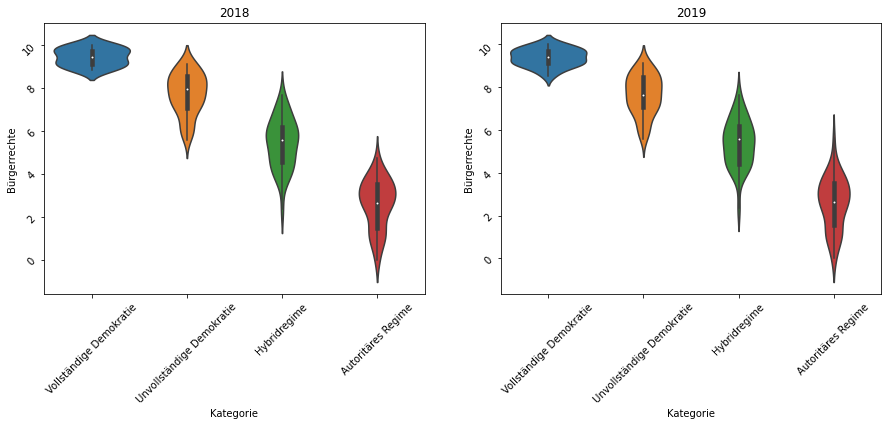

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
sns.violinplot(x = "Kategorie", y = "Bürgerrechte", data = df_INDEX2018, ax = ax[0])
sns.violinplot(x = "Kategorie", y = "Bürgerrechte", data = df_INDEX2019, ax = ax[1])
ax[0].title.set_text("2018")
ax[1].title.set_text("2019")
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
plt.show()

In [45]:
#Rename the columns of the EIU dataframe with more descriptive names
EIU_col = df_EIU.columns
#var that contains all numbers as string, needed to delete all numbers from strings
str_num = "0123456789"
#dict of more descriptive column names
dic_col = {"VA":"Demokratie",
           "PV":"Politische Stabilität",
           "GE":"Positive Bürokratie",
           "RQ":"Sozialer Markt",
           "RL":"Gesetz",
           "CC":"Korruptionsprävention"}

#Strip "EIU" from columns
EIU_cat1 = []
n = 0
for i in EIU_col:
    
    a = i[0]
    a = a.replace("EIU", "")
    
    #Strip year from columns
    if n > 1:
        a = a.strip(str_num)
    #renaming of the columns, try/except due to the columns that are not in the dict
    try:
        a = dic_col[a]
    except:
        pass
    EIU_cat1.append(a)    
    n += 1

#List of the years in the columns
EIU_cat2 = []
for i in EIU_col:
    EIU_cat2.append(i[1])

EIU_cat1[0] = "Land"

#Use new multicolumn
EIU_col_new = pd.MultiIndex.from_tuples(list(zip(EIU_cat1,EIU_cat2)))
df_EIU.columns = EIU_col_new
df_EIU.head(15)

,Land,Code,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,...,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention,Demokratie,Politische Stabilität,Positive Bürokratie,Sozialer Markt,Gesetz,Korruptionsprävention
,,Year,2019,2019,2019,2019,2019,2019,2018,2018,2018,2018,2018,2018,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2015,2015,2015,2015,2015,2015,2014,2014,2014,2014,2014,2014,2013,2013,...,2005,2005,2005,2005,2004,2004,2004,2004,2004,2004,2003,2003,2003,2003,2003,2003,2002,2002,2002,2002,2002,2002,2000,2000,2000,2000,2000,2000,1998,1998,1998,1998,1998,1998,1996,1996,1996,1996,1996,1996
0,Aruba,ABW,0.81250,0.75,0.625,0.7,0.84375,0.75,0.81250,0.75,0.625,0.7,0.84375,0.75,0.81250,0.8,0.625,0.85,0.84375,0.75,0.81250,0.8,0.625,0.9,0.84375,0.75,0.81250,0.8,0.625,0.9,0.84375,0.75,0.81250,0.8,0.625,0.9,0.84375,0.75,0.81250,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,0.17375,0.1,0,0.2,0.09375,0,0.17975,0.1,0,0.2,0.09375,0,0.15875,0.1,0,0.2,0.09375,0,0.15875,0.1,0,0.2,0.09375,0,0.16975,0.1,0,0.2,0.09375,0,0.16975,0.1,0,0.15,0.09375,0,0.15525,0.1,...,0.125,0.15,0.09375,0.00,0.0625,0.15,0.125,0.15,0.09375,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,0.34225,0.6,0.125,0.4,0.28125,0,0.33725,0.6,0.125,0.4,0.28125,0,0.30600,0.55,0.125,0.4,0.28125,0,0.29500,0.5,0.125,0.4,0.28125,0,0.29250,0.5,0.125,0.45,0.28125,0,0.29250,0.55,0.125,0.45,0.28125,0,0.29250,0.55,...,0.125,0.15,0.15625,0.00,0.1250,0.45,0.000,0.20,0.15625,0.00,0.0625,0.30,0.000,0.20,0.06250,0.00,0.0625,0.20,0.000,0.20,0.06250,0.00,0.0625,0.15,0.000,0.20,0.06250,0.00,0.0625,0.15,0.000,0.20,0.06250,0.00,0.0625,0.15,0.000,0.20,0.06250,0.00
3,Albania,ALB,0.57575,0.55,0.25,0.65,0.375,0.25,0.58025,0.6,0.25,0.6,0.375,0.25,0.58025,0.6,0.25,0.6,0.375,0.25,0.57675,0.55,0.25,0.6,0.375,0.25,0.57675,0.55,0.25,0.55,0.375,0,0.56475,0.55,0.25,0.55,0.375,0,0.56475,0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,ARE,0.23175,0.8,0.75,0.75,0.71875,0.75,0.23175,0.8,0.75,0.7,0.6875,0.75,0.22825,0.8,0.75,0.7,0.6875,0.75,0.23125,0.75,0.75,0.7,0.6875,0.75,0.23125,0.75,0.625,0.7,0.625,0.5,0.22575,0.75,0.5,0.65,0.59375,0.5,0.21975,0.75,...,0.500,0.80,0.53125,0.75,0.2500,0.75,0.500,0.80,0.53125,0.75,0.2500,0.75,0.500,0.80,0.53125,0.75,0.2500,0.70,0.500,0.80,0.53125,0.75,0.2500,0.75,0.500,0.75,0.56250,0.25,0.2500,0.75,0.500,0.75,0.56250,0.25,0.2500,0.75,0.500,0.75,0.56250,0.25
5,Argentina,ARG,0.63225,0.55,0.375,0.45,0.4375,0.5,0.63225,0.6,0.5,0.55,0.53125,0.5,0.62925,0.65,0.5,0.45,0.53125,0.5,0.62925,0.55,0.5,0.35,0.53125,0.5,0.60100,0.55,0.375,0.2,0.375,0.25,0.59200,0.5,0.375

In [46]:
#renaming the columns
df_INDEX2019_ISO.columns = ['Land', 'Dem_Score_Total', 'Electoral_process_pluralism',
       'Functioning_of_government', 'Political_participation',
       'Political_culture', 'Civil_liberties', 'Regime_type', 'Code2',
       'country_ger', 'country_en', 'Code3']

In [47]:
df_INDEX2019_ISO.head()

,Land,Dem_Score_Total,Electoral_process_pluralism,Functioning_of_government,Political_participation,Political_culture,Civil_liberties,Regime_type,Code2,country_ger,country_en,Code3
0,Norwegen,9.87,10.00,9.64,10.00,10.00,9.71,Vollständige Demokratie,NO,Norwegen,Norway,NOR
1,Island,9.58,10.00,9.29,8.89,10.00,9.71,Vollständige Demokratie,IS,Island,Iceland,ISL
2,Schweden,9.39,9.58,9.64,8.33,10.00,9.41,Vollständige Demokratie,SE,Schweden,Sweden,SWE
3,Neuseeland,9.26,10.00,9.29,8.89,8.13,10.00,Vollständige Demokratie,NZ,Neuseeland,New Zealand,NZL
4,Finnland,9.25,10.00,8.93,8.89,8.75,9.71,Vollständige Demokratie,FI,Finnland,Finland,FIN


# Dataset 3: Population data

Datacleaning and processing (done external so data can be stored in GitHub): Sebastian, (Philipp)

In [48]:
population = "https://raw.githubusercontent.com/supermonti1999/TechLabs_Projekt/main/POP_ISO.csv"
df_population = pd.read_csv(population, index_col = "Unnamed: 0")
#Info: Population given in 1000

#What: Adding a mean age per age-group
#Why: In order to be able to calculate the mean age of a population
df_population["AgeGrpMid"] = df_population["AgeGrpStart"] + 2
#Dropping not needed columns
df_population.drop(axis = 1, columns = ["Variant", "Time", "MidPeriod", "AgeGrpSpan"], inplace = True)

#Adjusting the "unit" of the population (total instead of 1k)
df_population["PopMale"] = df_population["PopMale"] * 1000
df_population["PopFemale"] = df_population["PopFemale"] * 1000
df_population["PopTotal"] = df_population["PopTotal"] * 1000

#Changing the order of the columns for cosmetic reasons
df_population = df_population[['Location', 'Code_3_digits', 'AgeGrp', 'AgeGrpStart', 'AgeGrpMid', 
                              'PopMale', 'PopFemale', 'PopTotal']]

#What: Create Dataframe of the Population Density with three Digit Codes
#Source: Data extracted from  https://population.un.org/wpp/Download/Standard/CSV/ for the Total Population and the Population Density. 
df= pd.read_csv('https://raw.githubusercontent.com/supermonti1999/TechLabs_Projekt/main/WPP2019_TotalPopulationBySex.csv')

#What:Filtering of the data for the relevant data
#Why: In order to extract the relevant data
Filter_2020=df['Time']==2020 
Filter_2020_v1=(df['Variant']=='Medium') 


df_POP_Density=df[Filter_2020_v1& Filter_2020]

#What: Modyfing the dataframe by eliminating the superfluos columns

df_POP_Density.head()
df_ISO_en.head() 
#Info: Population density per square kilometer(thousands)
#What:Add three digit codes for the countrys to the dataframe
#Why: In order to merge it with the "Master" dataframe
df_POP_Density= pd.merge(df_POP_Density, df_ISO_en, left_on='Location',right_on='country_en')

#Drop the unnecessary columns of the data
df_POP_Density=df_POP_Density[['PopDensity','Code3']]
#What: Check for Nan Values?
#Why:. To secure that the data fits
#df_POP_Density["Code_3_digits"].isnull().sum()
df_POP_Density.columns=['PopDensity_per_sq','Code3']
df_POP_Density.head()

,PopDensity_per_sq,Code3
0,59.627,AFG
1,105.029,ALB
2,18.411,DZA
3,275.985,ASM
4,164.394,AND


In [49]:
#Adding a column for the percentage of an age group in a population
df_population["AgePercPop"] = np.nan

#What: Creating a list of all individual countrys
#Why: In order to calculate the mean age and the percentage of each agegroup for each country separately
list_pop_ISO = df_population.Code_3_digits.unique()

#Calculation of the percentage of each age group in the population of the individual countrys
for i in list_pop_ISO:
    #Calculate the total population of a country
    sum_PopTotal = df_population.loc[df_population.Code_3_digits == i].PopTotal.sum()
    #Calculate the percentages, #"\" in order to start new line
    df_population.loc[df_population.Code_3_digits == i, "AgePercPop"] = \
    df_population.loc[df_population.Code_3_digits == i, "PopTotal"] / sum_PopTotal

    
#Calcuation of the mean age of each country AND    
#Caculation of the total population per country


#Adding a column (removed later) that is the product of Age and Population 
#AND the mean age of a country
#AND the Total population per country

df_population["Age_X_Pop"] = df_population["AgeGrpMid"] * df_population["PopTotal"]
df_population["AgeCountryMean"] = np.nan
df_population["PopTotalCountry"] = np.nan

for i in list_pop_ISO:
    sum_PopTotal = df_population.loc[df_population.Code_3_digits == i].PopTotal.sum()
    df_population.loc[df_population.Code_3_digits == i, "PopTotalCountry"] = sum_PopTotal    
    mean_age = df_population.loc[df_population.Code_3_digits == i, "Age_X_Pop"].sum()/sum_PopTotal
    df_population.loc[df_population.Code_3_digits == i, "AgeCountryMean"] = mean_age

#Dropping the not no longer needed column
df_population.drop(axis = 1, columns = ["Age_X_Pop"], inplace = True)

#Changing the order of the columns for cosmetic reasons
df_population = df_population[['Location', 'Code_3_digits', 'AgeGrp', 'AgeGrpStart', 'AgeGrpMid', 
                               'AgePercPop', 'AgeCountryMean','PopMale', 'PopFemale', 'PopTotal',
                               'PopTotalCountry']]

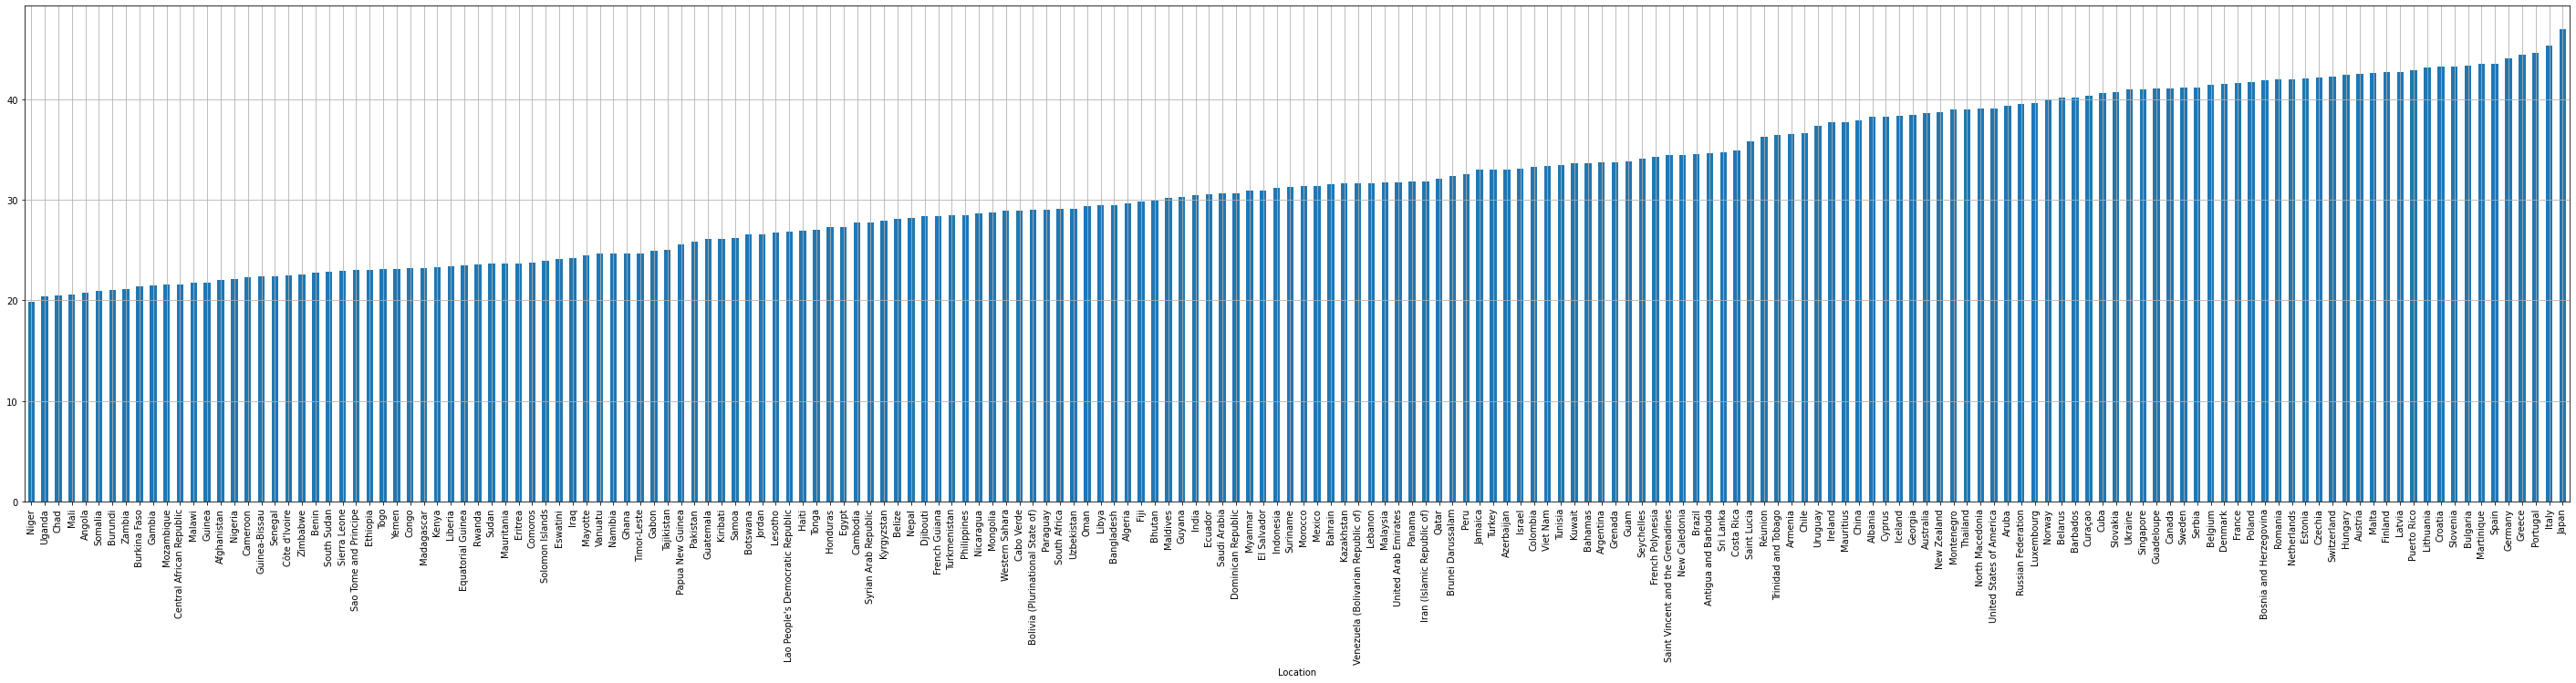

In [50]:
#Visualisation of the mean age per country in a bar plot (click to zoom)
plt.figure(figsize = (50,10))
df_population.groupby("Location").mean().AgeCountryMean.sort_values().plot.bar()
plt.grid(which="Major")
plt.show()

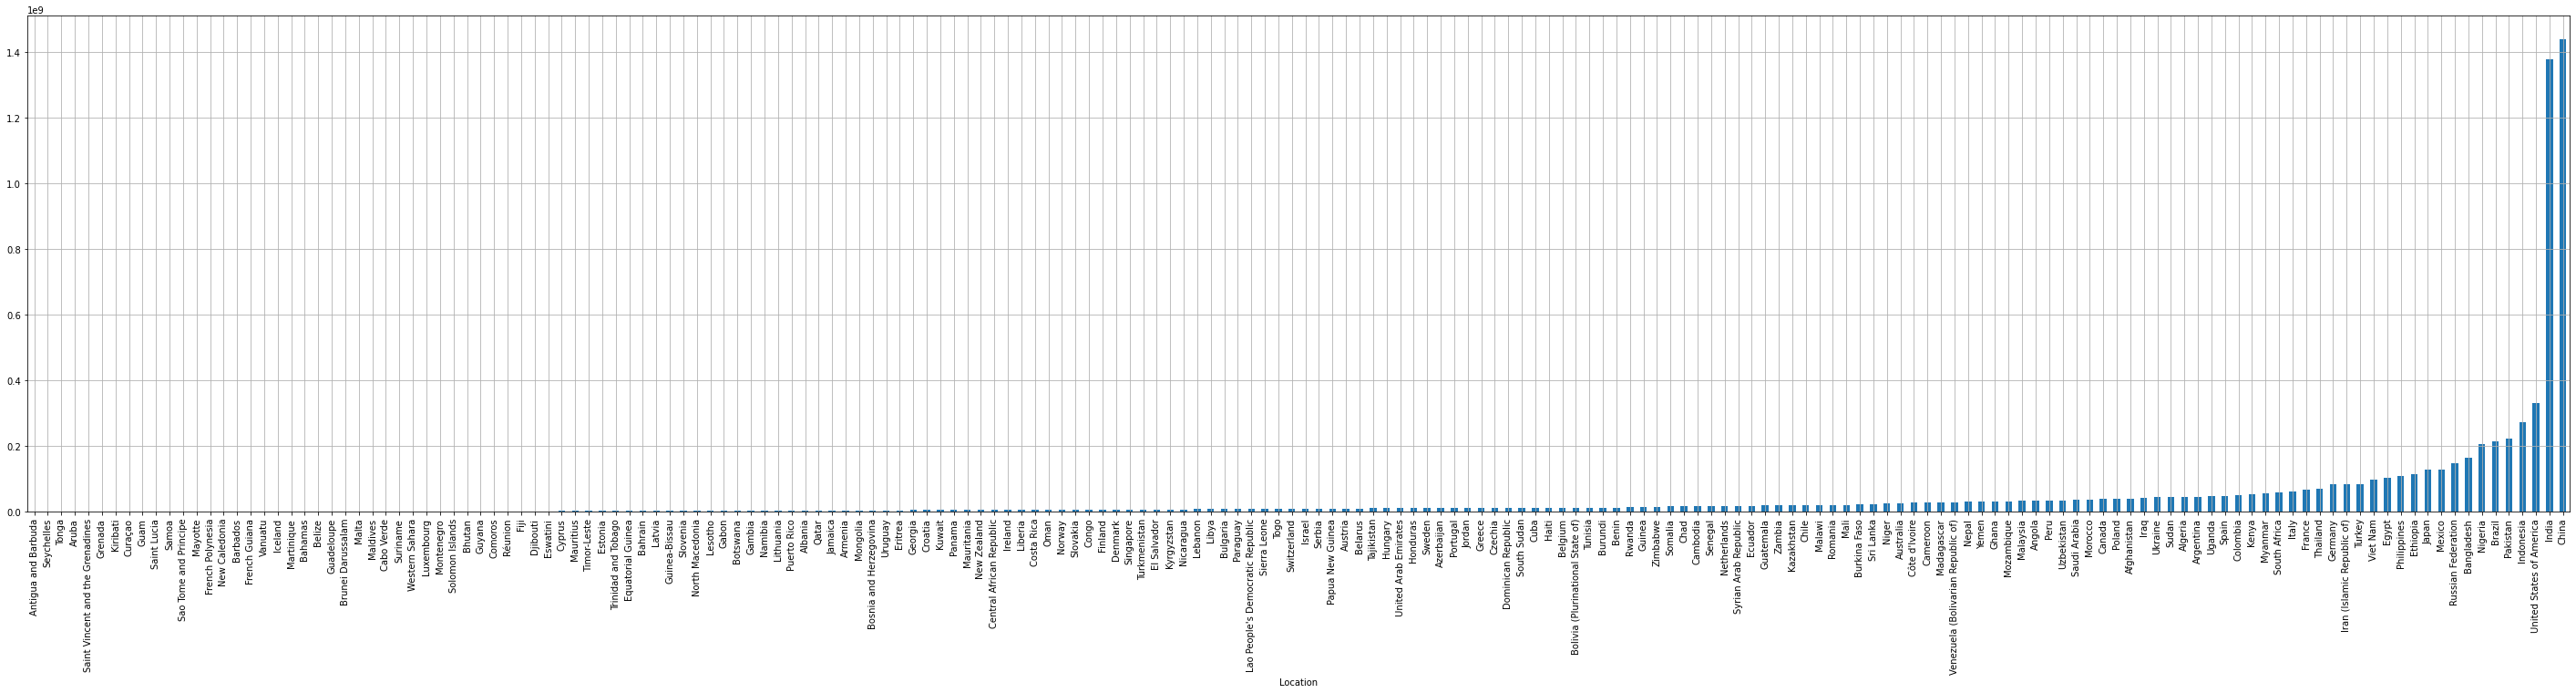

In [51]:
#Visualisation of the total population per country in a bar plot (click to zoom)
plt.figure(figsize = (50,10))
df_population.groupby("Location").mean().PopTotalCountry.sort_values().plot.bar()
plt.grid(which="Major")
plt.show()

#Dataset 4: Test statistics 

* Philipp, Kim 



In [52]:
#read dataframe
df_tests = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

In [53]:
df_tests["total_deaths_per_test"] = df_tests.total_deaths/df_tests.total_tests

In [54]:
df_tests["total_cases_per_test"] = df_tests.total_cases/df_tests.total_tests

In [55]:
#transform date to format datetime 
df_tests.date = pd.to_datetime(df_tests.date, format='%Y-%m-%d')

In [56]:
df_tests.loc[(df_tests['iso_code'] == 'ABW') & (df_tests['date']=="2020-03-13"), 'total_tests'] = 0


In [57]:
list_tests = [0]
for i in range(len(df_tests)-1):
    if (df_tests.iso_code[i]) != (df_tests.iso_code[i+1]):
        list_tests.append(i+1)
        

In [58]:
df_tests.loc[list_tests, 'total_tests'] = 0

In [59]:
# use forward fill to fill missing values 
df_tests.loc[:,'total_tests'] = df_tests.loc[:,'total_tests'].ffill()

In [60]:
# get number of tests per day by calculation of differences between days 
df_tests['tests_per_day'] = df_tests['total_tests'].diff()



In [61]:
# set first day to 0 (otherwise we'll have negative values on the first day)
df_tests.loc[list_tests, 'tests_per_day'] = 0
df_tests.loc[(df_tests['iso_code'] == 'ABW') & (df_tests['date']=="2020-03-13"), 'tests_per_day'] = 0


In [62]:
#rename columns to make it easier to merge df_tests with other dataframes
df_tests = df_tests.rename(columns={"date": "Date", "iso_code": "CountryCode"})


In [63]:
#drop all rows before Jan 01, 2020 and after Sep 22, 2020, drop all rows with location international because they don't contain relevant data  
df_tests.drop(df_tests[df_tests['Date'] >'2020-09-22'].index, inplace = True) 
df_tests.drop(df_tests[df_tests['Date'] <'2020-01-01'].index, inplace = True) 
df_tests.drop(df_tests[df_tests['location'] == 'International'].index, inplace = True) 

In [64]:
#create a slimmed down version of the dataframe
df_tests_redu = df_tests[["CountryCode", "Date", "total_tests" ]]
df_tests_redu2 = df_tests[["location", "total_cases", "total_deaths","total_tests", "total_deaths_per_test", "total_cases_per_test"]]

# Merging of the collected data

Putting together all the data: Philipp

In [65]:
#Grouping of the population data by country and dropping columns
df_population_aggr = df_population.groupby("Code_3_digits").mean()[["AgeCountryMean", "PopTotalCountry"]]
#Merging of the demcracy data and the population data
df_INDEX_POP = pd.merge(df_INDEX2019_ISO, df_population_aggr, how = "inner", left_on = "Code3", 
                        right_index= True)
df_INDEX_POP.reset_index(inplace=True, drop = True)


In [66]:
df_INDEX_POP = pd.merge(df_INDEX_POP, df_POP_Density, on='Code3',how='inner')

In [67]:
df_INDEX_POP

,Land,Dem_Score_Total,Electoral_process_pluralism,Functioning_of_government,Political_participation,Political_culture,Civil_liberties,Regime_type,Code2,country_ger,country_en,Code3,AgeCountryMean,PopTotalCountry,PopDensity_per_sq
0,Norwegen,9.87,10.00,9.64,10.00,10.00,9.71,Vollständige Demokratie,NO,Norwegen,Norway,NOR,39.999894,5421242.0,14.842
1,Island,9.58,10.00,9.29,8.89,10.00,9.71,Vollständige Demokratie,IS,Island,Iceland,ISL,38.355282,341250.0,3.404
2,Schweden,9.39,9.58,9.64,8.33,10.00,9.41,Vollständige Demokratie,SE,Schweden,Sweden,SWE,41.128764,10099270.0,24.612
3,Neuseeland,9.26,10.00,9.29,8.89,8.13,10.00,Vollständige Demokratie,NZ,Neuseeland,New Zealand,NZL,38.710924,4822233.0,18.314
4,Finnland,9.25,10.00,8.93,8.89,8.75,9.71,Vollständige Demokratie,FI,Finnland,Finland,FIN,42.711078,5540718.0,18.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Äquatorial Guinea,1.92,0.00,0.43,3.33,4.38,1.47,Autoritäres Regime,GQ,Äquatorial Guinea,Equatorial Guinea,GNQ,23.509314,1402985.0,50.017
150,Turkmenistan,1.72,0.00,0.79,2.22,5.00,0.59,Autoritäres Regime,TM,Turkmenistan,Turkmenistan,TKM,28.457950,6031187.0,12.834
151,Tschad,1.61,0.00,0.00,1.67,3.75,2.65,Autoritäres Regime,TD,Tschad,Chad,TCD,20.500142,16425859.0,13.045
152,Syrien,1.43,0.00,0.00,2.78,4.38,0.00,Autoritäres Regime,SY,Syrien,Syrian Arab Republic,SYR,27.726986,17500657.0,95.304


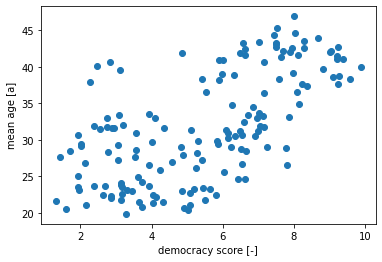

In [68]:
#Testplot, mean age versus democracy score
x = df_INDEX_POP["Dem_Score_Total"]
y = df_INDEX_POP["AgeCountryMean"]
plt.scatter(x,y)
plt.ylabel("mean age [a]")
plt.xlabel("democracy score [-]")
plt.show()

In [69]:
#Oxfort Dataframe, Index reset
ox.reset_index(inplace=True, drop = True)


### "Master"-Dataframe

In [70]:
#Merging into the "Master"-Dataframe
df_corona = pd.merge(ox, df_INDEX_POP, left_on = "CountryCode", right_on= "Code3", how = "inner")

In [71]:
#Dropping few columns
df_corona.drop(axis = 1, columns = ["Code2", "country_ger", "Land"], inplace = True)

In [72]:
df_corona.loc[df_corona.CountryCode == "DEU"].head()

,CountryName,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,ConfirmedCases,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,ConfirmedCases_per_day,ConfirmedDeaths_per_day,ConfirmedCases_per_day_shifted,ConfirmedDeaths_per_day_shifted,Days_Corona_in_Country,Dem_Score_Total,Electoral_process_pluralism,Functioning_of_government,Political_participation,Political_culture,Civil_liberties,Regime_type,country_en,Code3,AgeCountryMean,PopTotalCountry,PopDensity_per_sq
9044,Germany,DEU,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239,8.68,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783945.0,240.372
9045,Germany,DEU,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239,8.68,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783945.0,240.372
9046,Germany,DEU,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239,8.68,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783945.0,240.372
9047,Germany,DEU,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239,8.68,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783945.0,240.372
9048,Germany,DEU,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239,8.68,9.58,8.57,8.33,7.5,9.41,Vollständige Demokratie,Germany,DEU,44.028523,83783945.0,240.372


In [73]:
#What:Adding new columns that puts death into perspective
#Why: In order to secure comparability for the data
df_corona['ConCases_Pop']=df_corona['ConfirmedCases']/df_corona['PopTotalCountry']
df_corona['ConDeaths_Pop']=df_corona['ConfirmedDeaths']/df_corona['PopTotalCountry']
df_corona['ConCases_perDay_Pop']=df_corona['ConfirmedCases_per_day']/df_corona['PopTotalCountry']
df_corona['ConDeaths_perDay_Pop']=df_corona['ConfirmedDeaths_per_day']/df_corona['PopTotalCountry']
df_corona['ConCases_perDay_Pop_shifted']=df_corona['ConfirmedCases_per_day_shifted']/df_corona['PopTotalCountry']
df_corona['ConDeaths_perDay_Pop_shifted']=df_corona['ConfirmedDeaths_per_day_shifted']/df_corona['PopTotalCountry']

In [74]:
df_tests_redu[["Date", "CountryCode"]]

,Date,CountryCode
1,2020-01-01,AFG
2,2020-01-02,AFG
3,2020-01-03,AFG
4,2020-01-04,AFG
5,2020-01-05,AFG
...,...,...
53394,2020-09-18,OWID_WRL
53395,2020-09-19,OWID_WRL
53396,2020-09-20,OWID_WRL
53397,2020-09-21,OWID_WRL


#Merging Master Dataframe with df_tests_redu

In [75]:
df_corona = pd.merge(df_corona, df_tests_redu,  how='left', on=['CountryCode', 'Date'])


# Quality Checks 
(Check for mistakes that could result from data duplicates in source data)

In [76]:
#What: Test if unique keys (Combination of country and Date) ocurrs more than once in Dataframe (which would be an error)
#Why: This can happen, when in some of the dataframed joined, there is a mistake and duplicated rows exist. 
#Conclusion: All good-
#df_corona['CountryCodeDate']=df_corona.CountryCode +df_corona.Date.map(str)
#df_corona['CountryCodeDate'].nunique()
#df_corona['CountryCodeDate'].count()
#df_corona.groupby('CountryCodeDate').count()

In [77]:
#What: Test that all NaNs in ConfirmedCases have been successfully removed
df_corona[df_corona['ConfirmedCases_per_day'] < 0]
df_corona[df_corona['ConfirmedDeaths_per_day'] < 0]

,CountryName,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,ConfirmedCases,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,ConfirmedCases_per_day,ConfirmedDeaths_per_day,ConfirmedCases_per_day_shifted,ConfirmedDeaths_per_day_shifted,Days_Corona_in_Country,Dem_Score_Total,Electoral_process_pluralism,Functioning_of_government,Political_participation,Political_culture,Civil_liberties,Regime_type,country_en,Code3,AgeCountryMean,PopTotalCountry,PopDensity_per_sq,ConCases_Pop,ConDeaths_Pop,ConCases_perDay_Pop,ConDeaths_perDay_Pop,ConCases_perDay_Pop_shifted,ConDeaths_perDay_Pop_shifted,total_tests
8964,Czech Republic,CZE,2020-07-05,1.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,2.0,2.0,2.0,2.0,12440.0,351.0,34.72,45.83,43.06,62.5,121.0,-1.0,53.0,3.0,205,7.69,9.58,6.79,6.67,6.88,8.53,Unvollständige Demokratie,Czechia,CZE,42.207011,10708982.0,138.646,0.001162,0.000033,0.000011,-9.337956e-08,0.000005,2.801387e-07,573667.0
8965,Czech Republic,CZE,2020-07-06,1.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,2.0,2.0,2.0,2.0,12515.0,348.0,34.72,45.83,43.06,62.5,75.0,-3.0,59.0,1.0,205,7.69,9.58,6.79,6.67,6.88,8.53,Unvollständige Demokratie,Czechia,CZE,42.207011,10708982.0,138.646,0.001169,0.000032,0.000007,-2.801387e-07,0.000006,9.337956e-08,575381.0
11314,Spain,ESP,2020-05-22,3.0,2.0,2.0,4.0,1.0,2.0,1.0,4.0,2.0,2.0,0.0,2.0,2.0,1.0,3.0,234824.0,2794.0,75.46,74.70,72.57,87.5,1787.0,-25146.0,658.0,0.0,235,8.29,9.58,7.14,7.78,8.13,8.82,Vollständige Demokratie,Spain,ESP,43.543439,46754783.0,93.735,0.005022,0.000060,0.000038,-5.378273e-04,0.000014,0.000000e+00,2221497.0


# Feature Scaling (Normalization) (Laura)

In [78]:
#What: Look at min/max values of every column
#Why: To identify if we have any outliers in the data that would obscure the feature scaling by using the sklearn min/max scaler
#Conclusion: Only Date inconsitencies of the ConfirmedCases and ConfirmedDeaths have been found. Those data inconsistencies have therefore been removed under the DataCleaning section of the Oxford Response Tracker Dataset (ox). However, as ConfirmedCases and ConfirmedDeaths are Output Variables, this does not obscure Feature scaling activities of input variables. 

#df_corona.max(axis=0)
#df_corona.min(axis=0)
#df_corona[df_corona['ConfirmedCases_per_day'] < 0]

In [79]:
#What:Transfer Oridinal Scale of Regime_type (verbal description of state of democracy)into numeric scaled values 
#Why: In the following we use that order to normalize the values
df_corona.loc[df_corona['Regime_type'] =='Autoritäres Regime', 'Regime_type_num'] = 0
df_corona.loc[df_corona['Regime_type'] =='Hybridregime', 'Regime_type_num'] = 1
df_corona.loc[df_corona['Regime_type'] =='Unvollständige Demokratie', 'Regime_type_num'] = 2
df_corona.loc[df_corona['Regime_type'] =='Vollständige Demokratie', 'Regime_type_num'] = 3

In [80]:
#What: Apply sklearn min/max scaler to unify scale of input variables 
scaler=MinMaxScaler()
df_corona_norm = df_corona.copy()
df_corona_norm[['C1_School closing', 
'C2_Workplace closing', 
'C3_Cancel public events', 
'C4_Restrictions on gatherings', 
'C5_Close public transport', 
'C6_Stay at home requirements', 
'C7_Restrictions on internal movement', 
'C8_International travel controls', 
'E1_Income support', 
'E2_Debt/contract relief',  
'H1_Public information campaigns', 
'H2_Testing policy', 
'H3_Contact tracing', 
'H6_Facial Coverings', 
'StringencyIndex',
'GovernmentResponseIndex', 
'ContainmentHealthIndex', 
'EconomicSupportIndex', 
'Dem_Score_Total', 
'Electoral_process_pluralism', 
'Functioning_of_government', 
'Political_participation', 
'Political_culture', 
'Civil_liberties', 
'AgeCountryMean', 
'PopTotalCountry', 
'PopDensity_per_sq']] = scaler.fit_transform(df_corona_norm[['C1_School closing', 
'C2_Workplace closing', 
'C3_Cancel public events', 
'C4_Restrictions on gatherings', 
'C5_Close public transport', 
'C6_Stay at home requirements', 
'C7_Restrictions on internal movement', 
'C8_International travel controls', 
'E1_Income support', 
'E2_Debt/contract relief', 
'H1_Public information campaigns', 
'H2_Testing policy', 
'H3_Contact tracing',  
'H6_Facial Coverings', 
'StringencyIndex',
'GovernmentResponseIndex', 
'ContainmentHealthIndex', 
'EconomicSupportIndex', 
'Dem_Score_Total', 
'Electoral_process_pluralism', 
'Functioning_of_government', 
'Political_participation', 
'Political_culture', 
'Civil_liberties', 
'AgeCountryMean', 
'PopTotalCountry', 
'PopDensity_per_sq']
])

### Simple bar plots that visualisation the test data per country (double click to zoom)

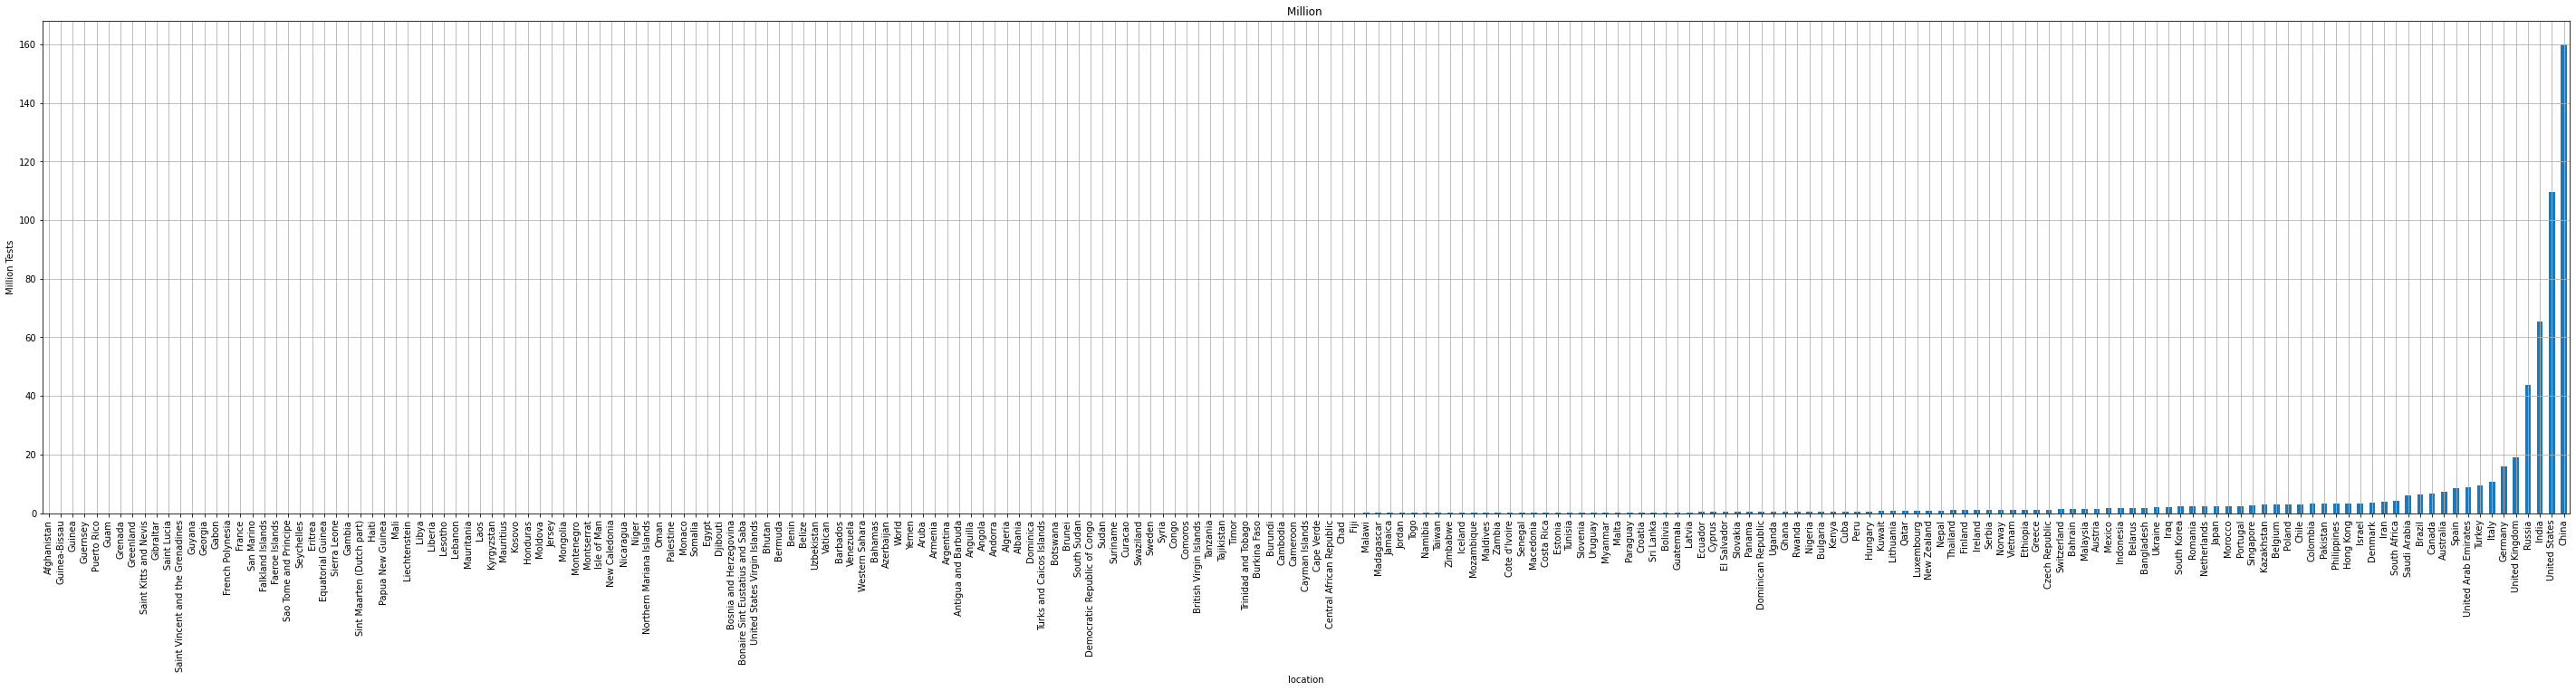

In [81]:
#Visualisation: Performed Tests per Country
plt.figure(figsize = (50,10))
plt.title("Million ")
data_plot = df_tests_redu2.groupby("location").max().total_tests.dropna().sort_values()/1000000
data_plot.plot.bar()
plt.ylabel("Million Tests")
plt.grid(which="Major")
plt.show()

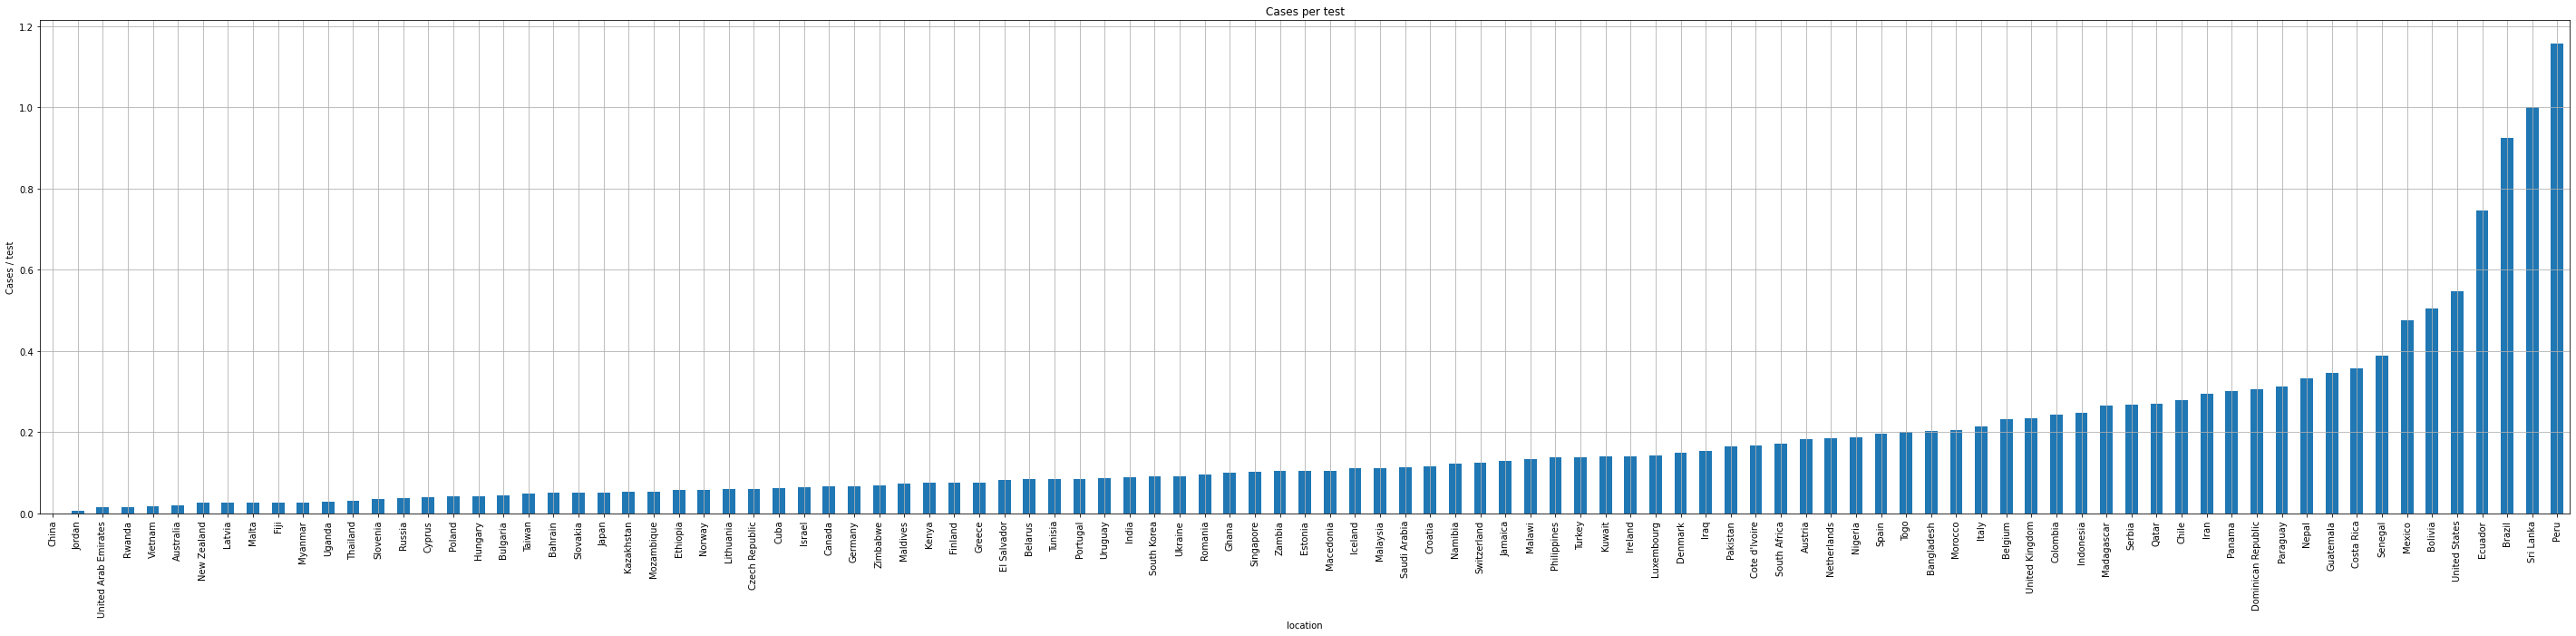

In [82]:
#Visualisation: Cases per test
plt.figure(figsize = (50,10))
plt.title("Cases per test")
df_tests_redu2.groupby("location").max().total_cases_per_test.dropna().sort_values().plot.bar()
plt.ylabel("Cases / test")
plt.grid(which="Major")
plt.show()

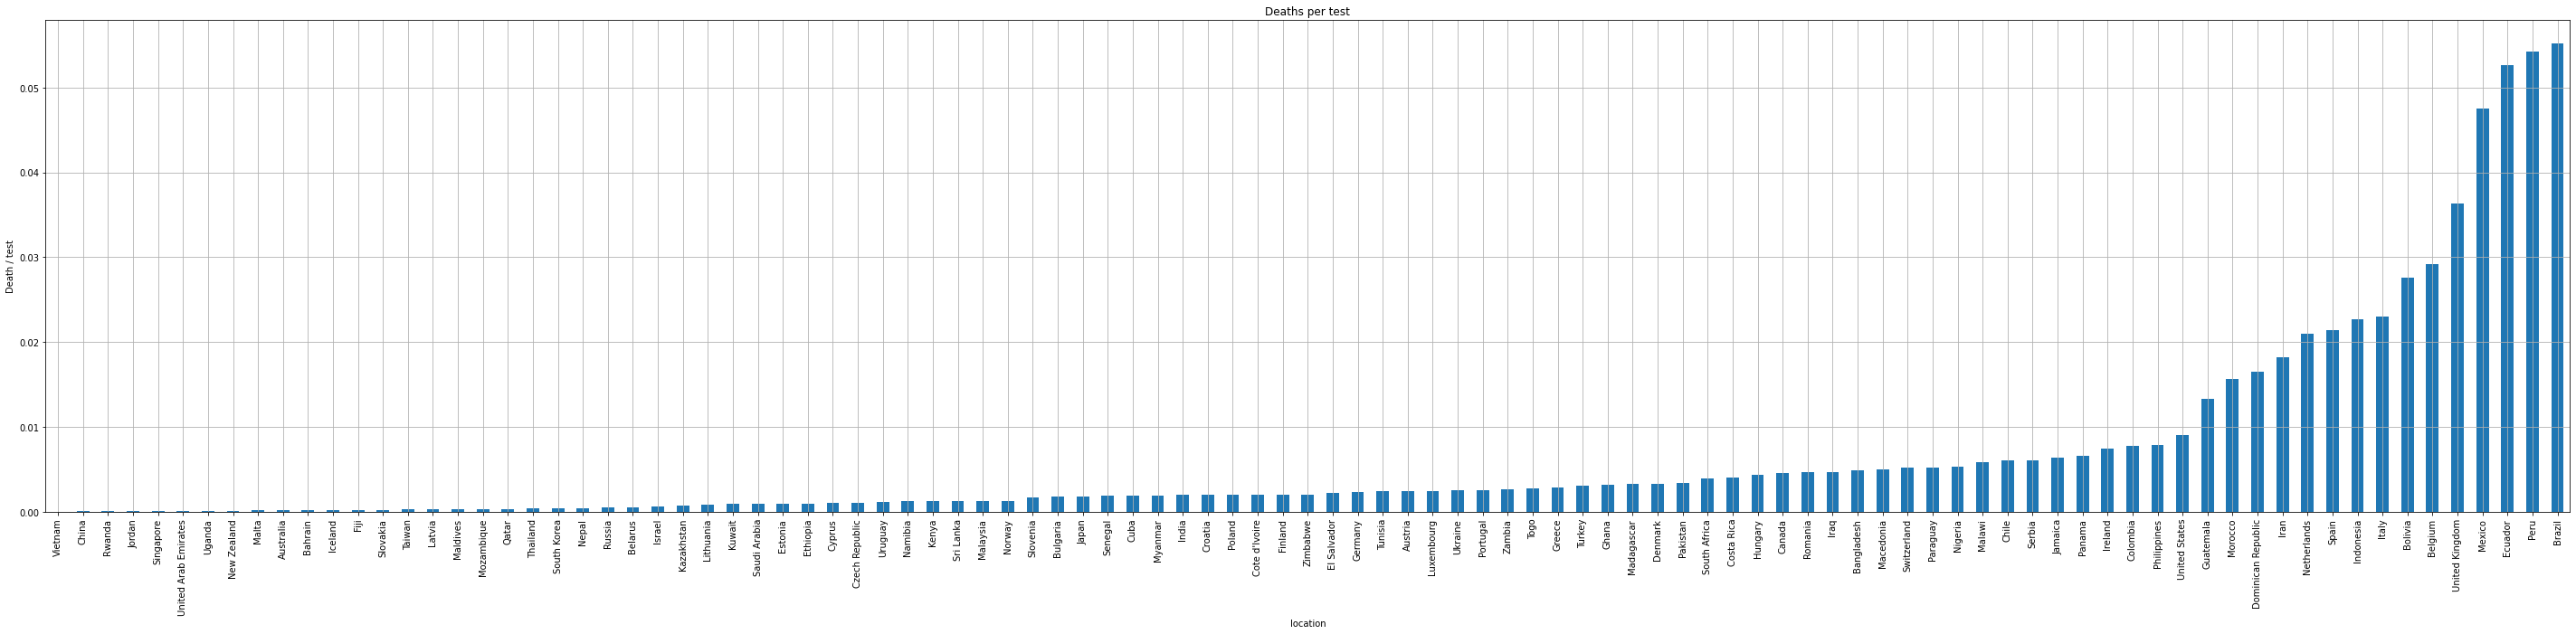

In [83]:
#Visualisation: Deaths per test
plt.figure(figsize = (50,10))
plt.title("Deaths per test")
df_tests_redu2.groupby("location").max().total_deaths_per_test.dropna().sort_values().plot.bar()
plt.ylabel("Death / test")
plt.grid(which="Major")
plt.show()

# Interactive Visualisations


#Interactive Display: Relation between the Oxford Government Response Index and number of new infections by day (select CountryCode)
The Oxford Government Response index displays what level of Corona fighting measures have been taken to fight the spread of the virus.
It comprises the level of: School closing, Workplace closing, Cancel public events, Restrictions on gatherings, Close public transport, Stay at home requirements, Restrictions on internal movement, International travel controls, Income support, Debt/contract relief, Fiscal measures, International support, Public information campaigns, Testing policy, Contact tracing, Emergency investment in healthcare, Investment in vaccines, Facial Coverings. 
The number of new infections displays not when the Infection was reported, but when it can be assumed that the person has been effected.

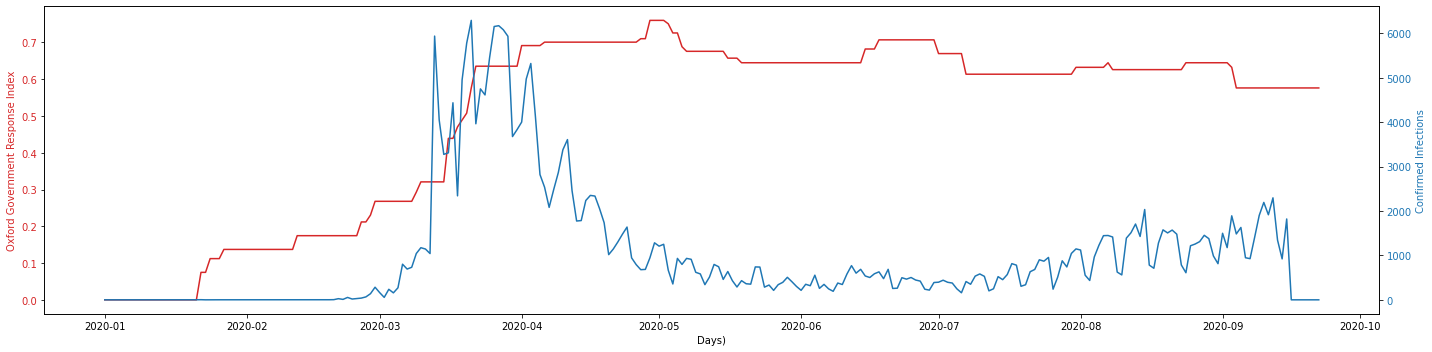

In [84]:
# To choose country on display type in CountryCode -->
df_country_filter=df_corona_norm.loc[df_corona_norm["CountryCode"]=="DEU"]
t = df_country_filter["Date"]
data1 = df_country_filter["GovernmentResponseIndex"]
data2 = df_country_filter["ConfirmedCases_per_day_shifted"]

fig, ax1 = plt.subplots(figsize = (20,5))

color = 'tab:red'
ax1.set_xlabel('Days)')
ax1.set_ylabel('Oxford Government Response Index', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Confirmed Infections', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Interactive Visualisation: How have different Regime Types reacted differently to Corona at chosen Dates (choose Date to compare)
Clusterd by Regime Type (level of democracy) display the extent of Corona fighting measures undertaken by countries as defined in the Oxford Government Response Index (Description of index: cf. Interactive Display: Relation between the Oxford Government Response Index and number of new infections by day)
Compare values over different days by selecting Dates.

In [85]:
# To choose country on display type in Dates -->

df_violin1=df_corona_norm[(df_corona_norm["Date"]=='20200301')]
df_violin2=df_corona_norm[(df_corona_norm["Date"]=='20200301')]
df_violin3=df_corona_norm[(df_corona_norm["Date"]=='20200301')]
df_violin4=df_corona_norm[(df_corona_norm["Date"]=='20200301')]

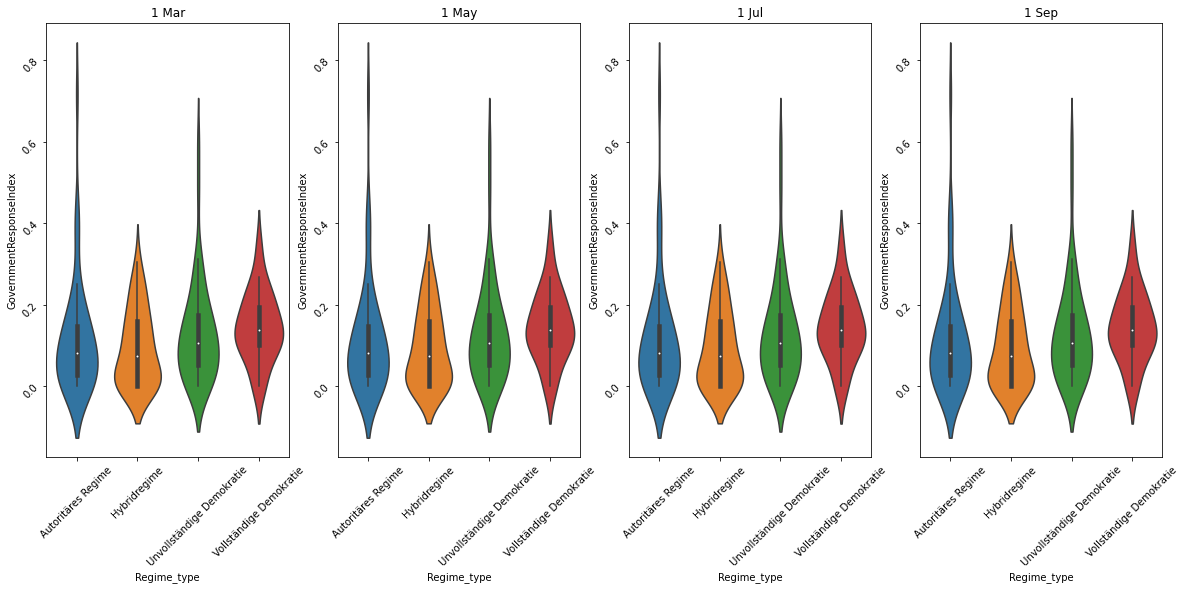

In [86]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20,8))
sns.violinplot(x = "Regime_type", y = "GovernmentResponseIndex", data=df_violin1, ax = ax[0])
sns.violinplot(x = "Regime_type", y = "GovernmentResponseIndex", data=df_violin2, ax = ax[1])
sns.violinplot(x = "Regime_type", y = "GovernmentResponseIndex", data=df_violin3, ax = ax[2])
sns.violinplot(x = "Regime_type", y = "GovernmentResponseIndex", data=df_violin4, ax = ax[3])

ax[0].title.set_text("1 Mar")
ax[1].title.set_text("1 May")
ax[2].title.set_text("1 Jul")
ax[3].title.set_text("1 Sep")
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)
ax[3].tick_params(labelrotation=45)
plt.show()

Conclusion: No striking difference in the extend of how to fight the spread of the Corona Virus varies betweeacrossn differen regime types can be observed. Only Authoritarian Regimes are observed to be least predictible in their measures. They seem to have at least some countries that follow any strategy from very strong to very weak levels of measures at any given time. 
The mean values of the Gounvernment Response Index of the democratic countrys however is higher at any time.

# Scatterplots over the democracy index
###### Select individual countrys by adding the name to the "my_countrys"-list

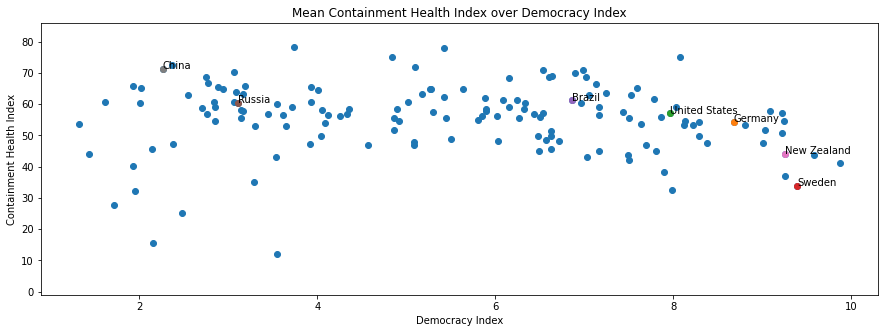

In [87]:
####Add/Remove countrys you want to have plotted individually
my_countrys = ["Germany", "United States", "Sweden", "Brazil", "Russia", "New Zealand", "China"]

x = df_corona.groupby("CountryName").max().Dem_Score_Total
y = df_corona.replace(0,np.nan).groupby("CountryName").mean().ContainmentHealthIndex

df_select_country = df_corona.replace(0,np.nan).groupby("CountryName").mean()

plt.figure(figsize = (15,5))
plt.scatter(x,y)

for i in my_countrys:
    y_select = df_select_country.loc[i, "ContainmentHealthIndex"] 
    x_select = df_select_country.loc[i, "Dem_Score_Total"]
    plt.scatter(x_select,y_select)
    plt.text(x_select,y_select, i)

plt.title("Mean Containment Health Index over Democracy Index")
plt.ylim(-1.,y.max()*1.1)
plt.xlabel("Democracy Index")
plt.ylabel("Containment Health Index")
plt.show()

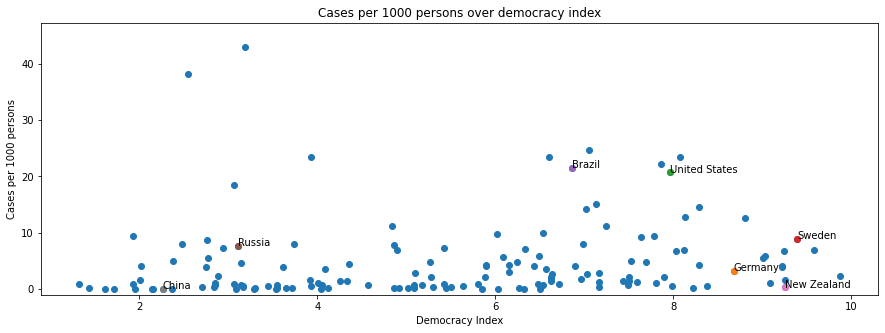

In [88]:
####Add/Remove countrys you want to have plotted individually
my_countrys = ["Germany", "United States", "Sweden", "Brazil", "Russia", "New Zealand", "China"]

x = df_corona.groupby("CountryName").max().Dem_Score_Total
y = df_corona.groupby("CountryName").max().ConCases_Pop * 1000

df_select_country = df_corona.groupby("CountryName").max()

plt.figure(figsize = (15,5))
plt.scatter(x,y)

for i in my_countrys:
    y_select = df_select_country.loc[i, "ConCases_Pop"] * 1000
    x_select = df_select_country.loc[i, "Dem_Score_Total"]
    plt.scatter(x_select,y_select)
    plt.text(x_select,y_select, i)

plt.title("Cases per 1000 persons over democracy index")
plt.ylim(-1.,y.max()*1.1)
plt.xlabel("Democracy Index")
plt.ylabel("Cases per 1000 persons")
plt.show()

In [89]:
#Calculate the deaths and the cases per test
df_corona["total_cases_per_Pop_Tests"] = df_corona["ConCases_Pop"]/df_corona["total_tests"]
df_corona["total_cases_per_Pop_Tests"].replace([np.inf, -np.inf], np.nan, inplace = True)

df_corona["total_deaths_per_Pop_Tests"] = df_corona["ConDeaths_Pop"]/df_corona["total_tests"]
df_corona["total_deaths_per_Pop_Tests"].replace([np.inf, -np.inf], np.nan, inplace = True)

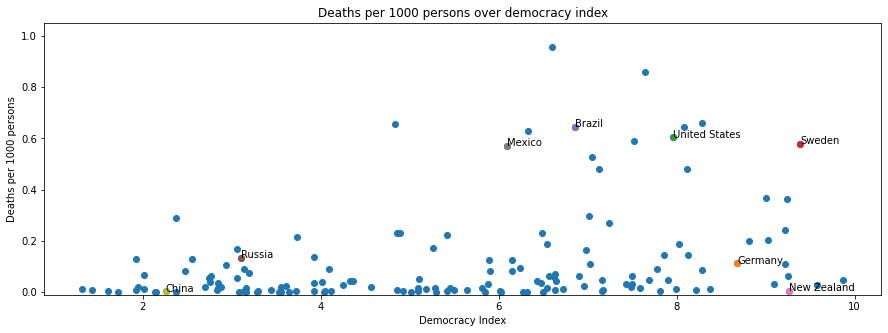

In [90]:
####Add/Remove countrys you want to have plotted individually
my_countrys = ["Germany", "United States", "Sweden", "Brazil", "Russia", "New Zealand", "Mexico", "China"]

x = df_corona.groupby("CountryName").max().Dem_Score_Total
y = df_corona.groupby("CountryName").max().ConDeaths_Pop * 1000

df_select_country = df_corona.groupby("CountryName").max()

plt.figure(figsize = (15,5))
plt.scatter(x,y)

for i in my_countrys:
    y_select = df_select_country.loc[i, "ConDeaths_Pop"] * 1000
    x_select = df_select_country.loc[i, "Dem_Score_Total"]
    plt.scatter(x_select,y_select)
    plt.text(x_select,y_select, i)

plt.title("Deaths per 1000 persons over democracy index")
plt.ylim(-0.01,y.max()*1.1)
plt.xlabel("Democracy Index")
plt.ylabel("Deaths per 1000 persons")
plt.show()

Sweden: no value


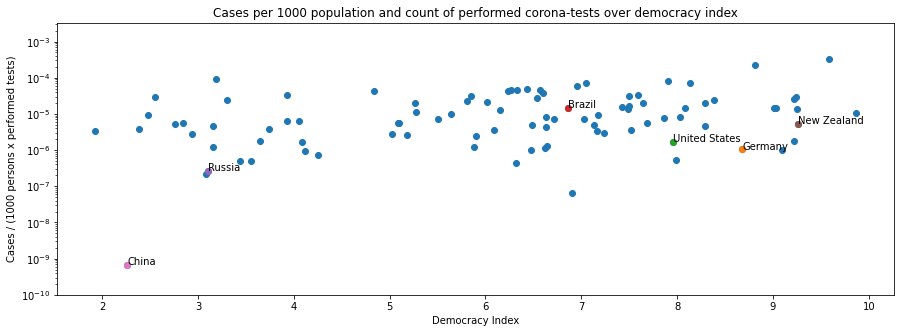

In [91]:
####Add/Remove countrys you want to have plotted individually
my_countrys = ["Germany", "United States", "Sweden", "Brazil", "Russia", "New Zealand", "China"]

x = df_corona.groupby("CountryName").max().Dem_Score_Total
y = df_corona.groupby("CountryName").max().total_cases_per_Pop_Tests * 1000

df_select_country = df_corona.groupby("CountryName").max()

plt.figure(figsize = (15,5))
plt.scatter(x,y)

for i in my_countrys:
    if df_select_country.loc[i, "total_cases_per_Pop_Tests"] > 0:
        y_select = df_select_country.loc[i, "total_cases_per_Pop_Tests"] * 1000
        x_select = df_select_country.loc[i, "Dem_Score_Total"]
        plt.scatter(x_select,y_select)
        plt.text(x_select,y_select, i)
    else: print(i+": no value")

plt.title("Cases per 1000 population and count of performed corona-tests over democracy index")
plt.yscale("log")
plt.ylim(10**(-10),y.max()*10)
plt.xlabel("Democracy Index")
plt.ylabel("Cases / (1000 persons x performed tests)")
plt.show()

Conclusion: The scatterplot does not show a general correlation between democracy index and corona cases and deaths. The lowest death and case numbers can be found for the countrys with the highest and the lowest democracy indices. This is due to the complexity of the global pandemic and the human societies. It is import how many people get tested ,if people get tested "randomly"/routinely or selectively, and if corona deaths are registered as such. Additionally it can be suspected that the data of democratic countrys tend to be more reliable and trustworthy compared to countrys without freedome of speech/science.

# Visualization: Barplot to illustrate the different handling of the corona pandemic regarding the governmental system
The data is clustered by regime type (level of democracy) and then the mean values of the different columns belonging to the government types are derived. The first barplot shows the mean of the corona cases reagrding the population, the second plot shows the average corona death Cases in relation to the Population and the last shows the mean of the government response index. 


In [93]:
#What: Adding a new columns that adds a weighted mean value grouped by the regime types.
#Why: In ordert to evade an overrepresenation of less populated countrys (Eurovision Song Contest Problem)
df_corona_grouped= df_corona_norm.groupby('Regime_type').sum()
df_corona_grouped['ConCases_Pop_Grouped']= df_corona_grouped['ConfirmedCases'] /df_corona_grouped['PopTotalCountry']
df_corona_grouped.head()

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,ConfirmedCases,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,ConfirmedCases_per_day,ConfirmedDeaths_per_day,ConfirmedCases_per_day_shifted,ConfirmedDeaths_per_day_shifted,Days_Corona_in_Country,Dem_Score_Total,Electoral_process_pluralism,Functioning_of_government,Political_participation,Political_culture,Civil_liberties,AgeCountryMean,PopTotalCountry,PopDensity_per_sq,ConCases_Pop,ConDeaths_Pop,ConCases_perDay_Pop,ConDeaths_perDay_Pop,ConCases_perDay_Pop_shifted,ConDeaths_perDay_Pop_shifted,total_tests,Regime_type_num,ConCases_Pop_Grouped
Regime_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Autoritäres Regime,7334.000000,5025.333333,7720.0,6101.50,4219.5,3692.666667,6134.0,7781.75,2611.5,3660.5,9.772241e+08,9237.0,5406.666667,6339.5,4240.25,2.972310e+08,6865875.0,6104.6959,5722.367909,5967.696241,2836.375,3502791.0,80948.0,3502732.0,80867.0,2437092,2202.977778,1525.244,2903.097510,3311.685039,4075.500000,3326.596,3560.039770,487.258430,199.398852,17.751246,0.158180,0.215070,0.002144,0.215070,0.002144,1.730568e+10,0.0,6.100068e+05
Hybridregime,5341.000000,3625.000000,5451.0,4799.50,2876.5,2911.666667,4065.5,5282.75,2246.0,3334.5,3.449131e+10,6794.0,3410.000000,4420.5,3281.75,1.445409e+08,3384991.0,4428.9169,4197.142453,4287.783448,2610.500,1959328.0,46140.0,1959328.0,46140.0,1670746,3672.044444,4867.268,3601.209544,3557.937008,3457.672414,4482.898,2354.984050,216.536949,167.083578,4.445348,0.131931,0.073086,0.002208,0.073086,0.002208,1.494410e+09,8512.0,6.675113e+05
Unvollständige Demokratie,7455.666667,5455.333333,8037.5,6830.00,3640.0,4004.000000,5779.5,8274.25,4721.5,6775.0,8.425571e+11,10572.0,5803.333333,7806.0,4814.50,1.434250e+09,55963725.0,6413.2046,6495.571070,6396.420574,5461.625,22696408.0,676098.0,22696408.0,676098.0,2658670,8398.444444,11199.664,8374.585062,7450.393701,6117.672414,9670.164,7230.814163,586.477681,452.946342,18.450430,0.718465,0.283408,0.008459,0.283408,0.008459,1.458556e+10,25536.0,2.445532e+06
Vollständige Demokratie,2477.000000,2359.666667,3192.0,2888.25,853.0,1182.333333,2014.5,3296.25,3507.5,2796.0,1.832164e+10,4586.0,3031.000000,3531.5,1255.75,2.246877e+08,15201211.0,2428.4054,2648.883923,2494.566188,2903.625,2536348.0,114589.0,2536407.0,114670.0,1204980,4899.066667,5441.030,5026.406639,4139.905512,4604.551724,5258.022,4219.717165,67.178687,84.852254,12.633016,0.589210,0.133000,0.004581,0.133003,0.004586,4.168662e+09,16758.0,3.344627e+06


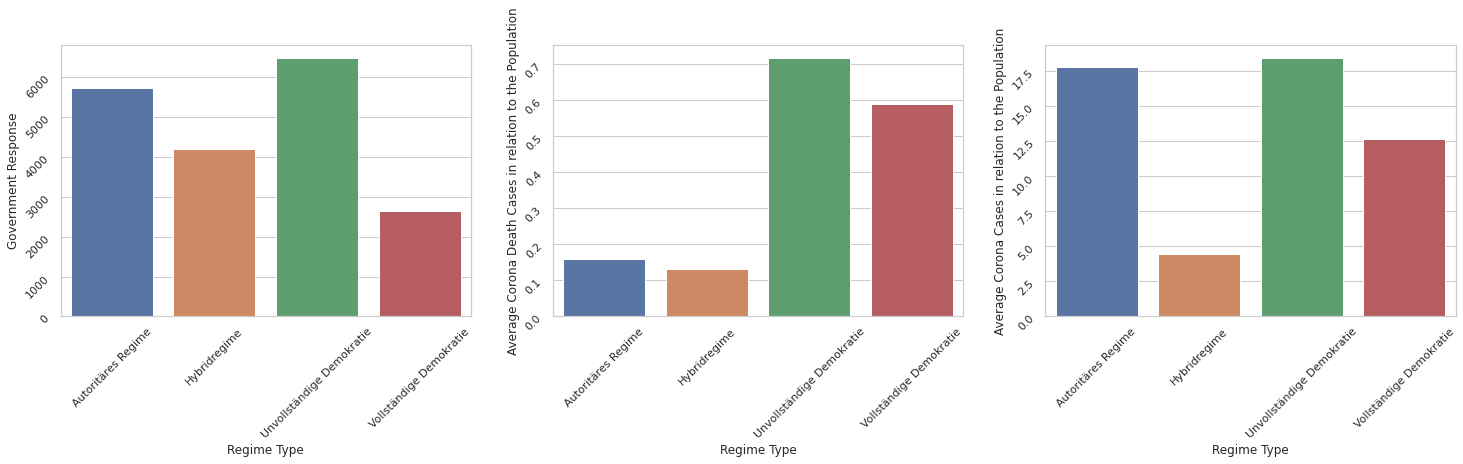

In [94]:
sns.set_theme(style="whitegrid")
df_barplot= (df_corona_grouped).reset_index()
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25,5))

bar1=sns.barplot(x='Regime_type',y='GovernmentResponseIndex', data=df_barplot, ax=ax[0])
bar1.set(xlabel='Regime Type', ylabel='Government Response')
bar1.tick_params(labelrotation=45)

bar2=sns.barplot(x='Regime_type',y='ConDeaths_Pop', data=df_barplot, ax=ax[1])
bar2.set(xlabel='Regime Type', ylabel='Average Corona Death Cases in relation to the Population')
bar2.tick_params(labelrotation=45)

bar3=sns.barplot(x='Regime_type',y='ConCases_Pop', data=df_barplot, ax=ax[2])
bar3.set(xlabel='Regime Type', ylabel='Average Corona Cases in relation to the Population')
bar3.tick_params(labelrotation=45)

plt.show() 

Interpretation: As we can see  the government response varies across als different types. The Democracys tend to have the lowest Government response.Whereas, the flawed democracys have the strongest government response. The average corona cases and corona death cases are much higher with the democracys. Thus, it may be that the people in authorian regimes had less problems with the pandemic because of the stronger countermeasures or the data provided by authorian regimes is not reported truthworthy. 

> Eingerückter Textblock



# Regression Attempts 
We want to find out how the measures documented in our dataframe are related to daily corona cases. Our dataset consists of longitudinal and crosssectional data, therefore we use a panel regression to analyze our data. It allows to control for both, the panel unit effect and the time effect. 


In [ ]:
#There are three different options: 
#ordinary least squared  --> we don't use this option as it is not suitable with imperfect measurements of data and limited availablity of data 
#Random Effects Model --> assumptions: regression parameter vary across groups, intercept can vary 
#Fixed Effects Model --> regression parameters are identical for all groups 

In [ ]:
#set index to panel data format 
data = df_corona.set_index(['CountryCode', 'Date'])

In [ ]:
#definition of independent variables --> we chose oxford indicators as independent variables  
inde_vars = data[['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 
                  'C4_Restrictions on gatherings', 'C5_Close public transport', 
                'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 
                'C8_International travel controls', 'E1_Income support', 
                'E2_Debt/contract relief','H1_Public information campaigns', 
                'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings']]

In [ ]:
#definition of dependent variables: Confirmed Cases per Day in relation to the countries population and 7 days shifted forward (due to incubation time etc.) 
de_var = data['ConCases_perDay_Pop_shifted']

In [ ]:
pip install linearmodels

In [ ]:
#Panel Regression (Random Effects Model)
from linearmodels.panel import RandomEffects

mod = RandomEffects(de_var, inde_vars)
re_res = mod.fit()
print(re_res)

In [ ]:
#Panel Regression (Fixed Effects Model)
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

exog = sm.add_constant(inde_vars)
mod = PanelOLS(de_var, exog, entity_effects=True)
fe_res = mod.fit()
print(fe_res)

In [ ]:
#comparison of both models 
from linearmodels.panel import compare
print(compare({'RE':re_res,'FE':fe_res}))

Interpretation: 
* even though r-squared is pretty low both models (fixed and random effect) are significant and results are similar in regard to the parameters
* parameters that are not significant (Workplace closing, stay at home requirements and contact tracing) 
* looking at the results, one could conclude that international travel controls, the cancellation of public events, dept/contract relief and public information campaigns are the most effective measures to lower corona cases  
* it even seems like that some measures might even increase corona cases 

**However, we have to be careful in interpreting the results as dynamics of the corona cases development are very complex.  Measures might take effect at different times and data might be incorrect (i.e. number of cases)**
